In [ ]:
#Date: 17/03/2021
#Authors: Jivesh Ramduny & Clare Kelly
#Location: Imaging Mind Architecture Lab, Trinity College Dublin


In [ ]:
#install the nltools, statsmodels and pingouin modules
!pip install nltools
!pip install pingouin
!pip install statsmodels


In [2]:
#install all modules required to perform ISC, IS-RSA, functional hyperalignment analyses
#%matplotlib inline

import os
import glob
import numpy as np
from numpy.fft import fft, ifft, fftfreq
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.animation import FuncAnimation
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import seaborn as sns
from nltools.data import Brain_Data, Adjacency
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import isc, isfc, isps, fdr, threshold, phase_randomize, circle_shift, _butter_bandpass_filter, _phase_mean_angle, _phase_vector_length, fisher_r_to_z, correlation_permutation
from nilearn.plotting import view_img_on_surf, view_img, plot_glass_brain, plot_stat_map
from sklearn.metrics import pairwise_distances
from sklearn.utils import check_random_state
from scipy.stats import ttest_1samp, rankdata, ttest_rel, shapiro, zscore, spearmanr
from scipy.signal import hilbert
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.manifold import TSNE
import networkx as nx
from IPython.display import HTML
from nilearn import plotting
from nilearn import signal
from nilearn import regions
import nibabel as nib
import pingouin as pg


/usr/local/lib/python3.7/dist-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


### Network & content Labels

In [ ]:
#spatial coverage of the functional networks derived from Finn et al. (2015)

medial_frontal = [9, 11, 15, 51, 52, 53, 55, 56, 63, 64, 136, 139, 144, 147, 148, 149, 150, 152, 155, 161, 164, 182, 184, 185, 186, 189, 191, 193, 218]
frontoparietal = [0, 3, 6, 7, 8, 13, 16, 18, 20, 21, 29, 30, 46, 47, 54, 69, 110, 111, 115, 138, 141, 142, 146, 153, 156, 163, 181, 183, 192, 195, 198, 241, 245, 246]
frontoparietal_1_2 = [9, 11, 15, 51, 52, 53, 55, 56, 63, 64, 136, 139, 144, 147, 148, 149, 150, 152, 155, 161, 164, 182, 184, 185, 186, 189, 191, 193, 218, 0, 3, 6, 7, 8, 13, 16, 18, 20, 21, 29, 30, 46, 47, 54, 69, 110, 111, 115, 138, 141, 142, 146, 153, 156, 163, 181, 183, 192, 195, 198, 241, 245, 246]
default_mode = [2, 4, 5, 12, 48, 49, 84, 85, 89, 95, 114, 133, 137, 140, 202, 221, 222, 224, 226, 238]
subcortical_cerebellum = [1, 10, 14, 17, 19, 27, 28, 31, 35, 43, 82, 87, 90, 92, 93, 94, 98, 100, 102, 103, 104, 105, 106, 107, 109, 112, 113, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 134, 135, 143, 145, 151, 154, 168, 177, 216, 219, 220, 223, 225, 228, 229, 230, 231, 232, 233, 235, 236, 237, 242, 243, 244, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267]
motor = [22, 23, 24, 25, 26, 32, 33, 34, 36, 37, 38, 39, 44, 45, 50, 57, 59, 60, 61, 62, 83, 88, 91, 96, 108, 157, 158, 159, 160, 162, 165, 166, 167, 169, 170, 171, 172, 173, 178, 179, 180, 187, 188, 190, 194, 196, 201, 217, 227, 234]
visual_I = [41, 67, 71, 74, 76, 78, 79, 81, 86, 97, 175, 197, 204, 206, 207, 210, 214, 215]
visual_II = [75, 77, 80, 99, 101, 211, 212, 213, 240]
visual_assoc = [40, 42, 58, 65, 66, 68, 70, 72, 73, 174, 176, 199, 200, 203, 205, 208, 209, 239]

#spatial coverage of the limbic network derived from Yeo 7Network and Harvard-Oxford atlases
limbic = [136, 0, 138, 57, 230, 185, 51, 50, 59, 134, 201, 1, 98, 96, 2, 58, 234, 95, 17, 233, 184, 56, 227, 3, 194, 188, 193, 91, 135, 55, 94, 133, 258, 254, 187, 102, 195, 231, 93, 151, 124, 250, 200, 116, 54, 232, 92, 16, 52, 152, 5, 114, 118, 236, 140, 103, 244, 266, 255, 228, 235, 229, 192, 132, 122, 100, 238, 35, 104, 197, 243, 107, 249, 109, 137, 186, 97, 253, 125, 111, 129, 206, 204, 108, 106, 105, 112, 70, 150, 226, 242, 239, 101, 237, 66, 75, 168]

#spatial coverage of the cognitive, intermediate and affective clusters derived from Schurz et al. (2021)
cognitive = [182, 9, 46, 47, 63, 139, 89, 224, 4, 49, 60, 218, 137, 52, 64, 144, 181, 11, 62, 202, 5, 2, 82, 14, 147, 175, 196, 221, 189, 183, 222, 140, 41, 85, 133, 84, 187, 55, 33, 54, 149, 136, 48, 220, 90, 76, 225, 177, 83, 0, 191, 15, 43, 219, 35, 27, 45, 258, 223, 91, 192, 87, 51, 138, 262, 88, 56, 127, 124, 217, 36, 8, 34, 184, 193, 208, 226, 160, 73, 98, 264, 214, 257, 20, 68, 185, 186, 122, 19, 42, 195, 120, 44, 81, 227, 53, 58, 162, 131, 190]
intermediate = [182, 64, 60, 46, 63, 191, 89, 224, 15, 62, 49, 52, 9, 196, 47, 149, 187, 190, 45, 147, 218, 150, 33, 202, 183, 20, 139, 155, 222, 14, 168, 35, 18, 181, 144, 221, 84, 27, 55, 262, 220, 11, 90, 225, 162, 34, 189, 127, 208, 19, 36, 39, 154, 83, 68, 160, 82, 175, 53, 180, 120, 177, 48, 219, 153, 7, 85, 41, 91, 252, 161, 24, 76, 152, 54, 43, 192, 73, 124, 4, 122, 212, 237, 247, 137, 56, 179, 87, 264, 217, 206, 66, 88, 51, 169, 223, 167, 258, 156, 253, 98, 28, 226, 21, 44, 17, 16, 123, 131, 260, 186, 240, 61, 133, 121, 109, 75, 69, 198, 140]
affective = [20, 180, 150, 155, 60, 45, 15, 22, 149, 162, 156, 218, 168, 33, 14, 27, 66, 35, 19, 34, 18, 227, 44, 64, 123, 36, 187, 154, 91, 39, 220, 191, 75, 167, 158, 146, 190, 160, 98, 169, 170, 83, 152, 260, 153, 147, 80, 52, 21, 183, 82, 262, 26, 172, 46, 161, 124, 73, 208, 7, 213, 219, 139, 68, 230, 77, 11, 49, 9, 113, 142, 223, 63, 61, 179, 62, 88, 30, 32, 212, 24, 112, 87, 217, 28, 182, 16, 127, 157, 222, 206, 71, 65, 164, 53, 144, 258, 70, 237, 264, 196, 211, 101, 109, 13, 257, 151, 17, 209, 84, 148, 51, 234, 205, 252, 185, 199, 131, 125, 178, 240, 261, 10, 67, 96, 197, 202]

#spatial coverage of the theory of mind network for social animations (SA) and empathy network for observing emotions (OE) derived from Schurz et al. (2021)
SA = [64, 191, 60, 196, 190, 49, 182, 162, 46, 155, 63, 45, 187, 52, 70, 180, 199, 15, 169, 62, 33, 20, 197, 47, 189, 18, 39, 208, 36, 65, 61, 237, 179, 53, 156, 200, 172, 55, 22, 183, 68, 66, 244, 9, 168, 192, 11, 202, 146, 206, 112, 34, 91, 167, 139, 44, 253, 218, 205, 154, 67, 73, 28, 133, 147, 48, 144, 198, 109, 19, 2, 71, 150, 35, 233, 21, 252, 56, 51, 27, 4, 69, 195, 137]
OE = [20, 15, 98, 227, 66, 230, 60, 91, 36, 33, 123, 35, 34, 18, 96, 112, 124, 65, 19, 21, 80, 234, 70, 187, 73, 150, 39, 30, 168, 7, 258, 209, 262, 109, 113, 213, 75, 67, 260, 264, 71, 152, 205, 127, 13, 169, 101, 17, 95, 26, 211, 154, 22, 16, 156, 93, 118, 212, 155, 50, 52, 185, 206, 197, 261, 146, 131, 77, 61, 134, 240, 125, 63, 214, 253, 194, 94, 199, 200, 237, 51, 57, 129, 10]


### Load the NARSAD timeseries

In [3]:
#read the timeseries of all participants into a 3D array

data_dir = np.sort(glob.glob('/content/drive/MyDrive/Year2/NARSAD3/*_task-thepresent_nuisance_regressed_shen_2mm_268.txt'))
sub_list = [os.path.basename(x).split('_')[0] for x in data_dir]

timeseries = []
sub_timeseries = {}

for filename in data_dir:

  shen = np.loadtxt(filename)
  shen_df = pd.DataFrame(shen)
  shen_df.reset_index(inplace = True, drop = True)
  shen_df_to_array = shen_df.to_numpy()
  timeseries.append(shen_df_to_array)

timeseries_3D = np.array(timeseries)


In [4]:
#convert the timeseries of all participants to a dataframe

timeseries_reg = {}

for sub in range(timeseries_3D.shape[0]):

  timeseries_reg[sub] = pd.DataFrame(timeseries_3D[sub, :, :])


In [5]:
#standardise the timeseries by z-transforming the timesries and store it in a dataframe

standardise_df = {}
timeseries_reg = {}

for sub in range(timeseries_3D.shape[0]):

  standardise_df[sub] = signal.clean(timeseries_3D[sub, :, :], detrend = False, standardize = 'zscore', standardize_confounds = False, t_r = None)
  timeseries_reg[sub] = pd.DataFrame(standardise_df[sub])


### Compute the mean framewise displacement of all individuals

In [ ]:
#compute the mean FD of all individuals to check if they have meet the cut-off motion threshold of 0.3mm

confound_dir = np.sort(glob.glob('/content/drive/MyDrive/Year2/confounds/*_task-thepresent_desc-confounds_regressors.tsv'))
confound_vars = ['framewise_displacement']

FD = []

for file in confound_dir:
  
  sub = os.path.basename(file).split('_')[0]
  confound_df = pd.read_csv(file, delimiter = '\t')
  confounds_df = confound_df[confound_vars]
  confounds_to_array = confounds_df.to_numpy()
  mFD_df = confounds_df.mean(axis = 0)
  FD.append(mFD_df)

np.savetxt('/content/drive/MyDrive/Year2/mean_FD.txt', FD)


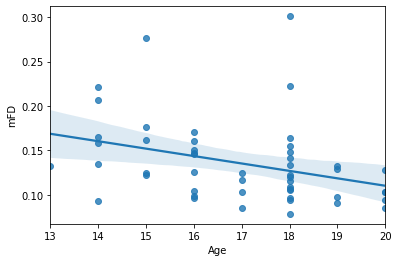

In [ ]:
#plot the relationship between head motion and age

path = "/content/drive/MyDrive/Year2/age_motion_narsad.csv"
motion_df = pd.read_csv(path)
sns.regplot(data = motion_df, x = 'Age', y = 'mFD')

#plt.savefig('/content/drive/MyDrive/Year2/motion_age.png')


## Functional Connectivity (FC) Analysis

### Visualise FC Matrix

In [6]:
timeseries_array = []

for sub in range(len(sub_list)):

  timeseries = timeseries_reg[sub].to_numpy()
  timeseries_array.append(timeseries)

timeseries_array = np.array(timeseries_array)


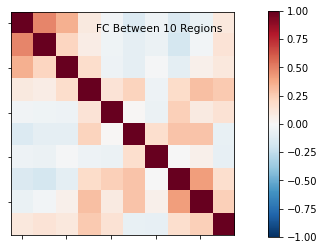

In [8]:
from nilearn.connectome import ConnectivityMeasure

cm = ConnectivityMeasure(kind='correlation')
correlations = []

rois = ['R_Amyg', 'L_Amyg', 'R_OFC', 'L_vlPFC', 'L_dlPMC', 'L_dlPFC', 'R_dlPFC', 'R_aPFC', 'L_rACC', 'L_aINS']
neurosynth = [99, 231, 18, 151, 162, 149, 14, 144, 219, 169]
neuro_roi_index = [98, 230, 17, 150, 161, 148, 13, 143, 218, 168]

timeseries_neurosynth = np.take(timeseries_array, neuro_roi_index, axis = 2)

for i in range(timeseries_neurosynth.shape[0]):

  corr_mat = cm.fit_transform([timeseries_neurosynth[i, :, :]])
  correlations.append(corr_mat)

corr = np.squeeze(np.array(correlations))

mean_correlations = np.mean(corr, axis = 0).reshape(corr.shape[1], corr.shape[1])
plotting.plot_matrix(mean_correlations, vmax = 1, vmin = -1, colorbar = True, label = 'rois', title = 'FC Between 10 Regions', figure = (4,4))

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 5})

#plt.savefig('/content/drive/MyDrive/Year2/FC_10Regions.png')


### Relationships between FC and BDI-Y/CERQ scores

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


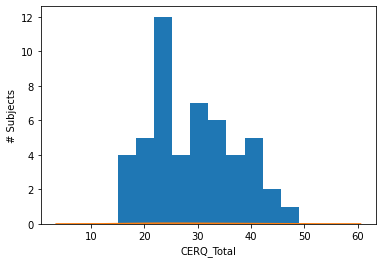

In [ ]:
#load the behavioural measures: (1) BDI-Y which assessed the severity of depressive symptoms in youths - (2) CERQ which measured the cognitive emotional regulation in adolescents

behav_data_BDI = pd.read_csv('/content/drive/MyDrive/Year2/behav_narsad_data.csv')
behav_data_adap_CERQ = pd.read_csv('/content/drive/MyDrive/Year2/adaptive_strategy_CERQ.csv')
behav_data_maladap_CERQ = pd.read_csv('/content/drive/MyDrive/Year2/maladaptive_strategy_CERQ.csv')

behav = behav_data_maladap_CERQ["CERQ_Total"]
plt.hist(behav)
plt.xlabel('CERQ Scores')
plt.ylabel('# Subjects')
sns.distplot(behav)

behav_rank = rankdata(behav)


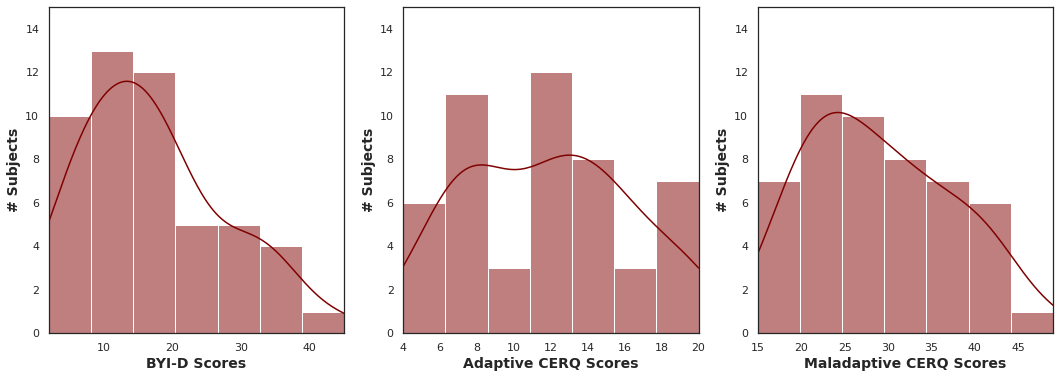

In [ ]:
sns.set(style="white")

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
sns.histplot(data=behav_data_BDI, x="BDI", kde=True, fill = True, color = 'maroon')
plt.xlabel('BYI-D Scores', fontweight ='bold', fontsize = 14)
plt.ylabel('# Subjects',  fontweight ='bold', fontsize = 14)
plt.xlim(2, 45)
plt.ylim(0, 15)

plt.subplot(1, 3, 2)
sns.histplot(data=behav_data_adap_CERQ, x="CERQ_Total", kde=True, color = 'maroon')
plt.xlabel('Adaptive CERQ Scores', fontweight ='bold', fontsize = 14)
plt.ylabel('# Subjects',  fontweight ='bold', fontsize = 14)
plt.xlim(4, 20)
plt.ylim(0, 15)

plt.subplot(1, 3, 3)
sns.histplot(data=behav_data_maladap_CERQ, x="CERQ_Total", kde=True, color = 'maroon')
plt.xlabel('Maladaptive CERQ Scores', fontweight ='bold', fontsize = 14)
plt.ylabel('# Subjects',  fontweight ='bold', fontsize = 14)
plt.xlim(15, 49)
plt.ylim(0, 15)


plt.savefig('/content/drive/MyDrive/Year2/phenotypic_distribution.png')


In [ ]:
from nilearn.connectome import ConnectivityMeasure

cm = ConnectivityMeasure(kind = 'correlation', vectorize = True, discard_diagonal = True)
correlations = []

rois = ['R_Amyg', 'L_Amyg', 'R_OFC', 'L_vlPFC', 'L_dlPMC', 'L_dlPFC', 'R_dlPFC', 'R_aPFC', 'L_rACC', 'L_aINS']
neurosynth = [99, 231, 18, 151, 162, 149, 14, 144, 219, 169]
neuro_roi_index = [98, 230, 17, 150, 161, 148, 13, 143, 218, 168]

timeseries_neurosynth = np.take(timeseries_array, neuro_roi_index, axis = 2)

for i in range(timeseries_neurosynth.shape[0]):

  corr_mat = cm.fit_transform([timeseries_neurosynth[i, :, :]])
  correlations.append(corr_mat)

corr = np.squeeze(np.array(correlations))

mean_r, mean_p, perm_dis = {}, {}, {}

for edge in range(corr.shape[1]):

  stats = correlation_permutation(corr[:, edge], behav, method = 'permute', return_perms = True, n_permute = 5000, metric = 'spearman', n_jobs = -1, random_state = None)
  mean_r[edge], mean_p[edge] = stats['correlation'], stats['p']
  perm_dis[edge] = stats['perm_dist']


In [ ]:
#apply FDR correction to adjust the p values for multiple comparisons across the edges

p_val = np.array(list(mean_p.items()))
p_val_fdr = p_val[:, 1]
fdr(p_val_fdr)

import statsmodels as sm
sm.stats.multitest.fdrcorrection(p_val_fdr, alpha = 0.05, method = 'i', is_sorted = False)


In [ ]:
np.where(pd.Series(mean_p).values <= 0.01)

(array([], dtype=int64),)

### Display null distribution and observed mean (Sperman's Rank) correlation

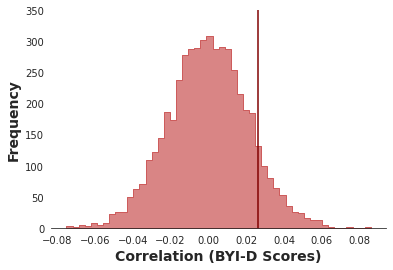

In [ ]:
#display the null distribution from the permutation tests and observed mean correlation (Spearman's Rank) across 268 parcels

perm_array = np.array(list(perm_dis.values()))
mean_perm = np.mean(perm_array, axis = 0)
sns.histplot(mean_perm, element="step", color = 'indianred')

plt.axvline(0.026, color = 'maroon', linestyle = '-');
plt.ylabel('Frequency', fontweight ='bold', fontsize = 14)
plt.xlabel('Correlation (BYI-D Scores)', fontweight ='bold', fontsize = 14)

plt.ylim(0, 350)
sns.set_style("white")
sns.despine(left=True)

#plt.savefig('/content/drive/MyDrive/Year2/ISC_maladapCERQ_Null_Distribution_fullmovie.png')


In [ ]:
np.mean(np.array(list(mean_r.values())))

0.026169126109731437

In [ ]:
#compute significance of the observed mean correlation (Spearman's Rank) as described in Gruskin et al. (2020)

isc_r_array = np.array(list(mean_r.values()))
mean_isc_r = np.mean(isc_r_array)
p_val = (2 + np.sum(mean_perm <= mean_isc_r)) / 5002
p_val

0.9018392642942823

## Hurst Exponent

In [9]:
!pip install hurst

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Using hurst module

In [ ]:
#compute the Hurst Exponent (HE) from a given timeseries at the ROI level

from hurst import compute_Hc, random_walk

rois = ['R_Amyg', 'L_Amyg', 'R_OFC', 'L_vlPFC', 'L_dlPMC', 'L_dlPFC', 'R_dlPFC', 'R_aPFC', 'L_rACC', 'L_aINS']
neurosynth = [99, 231, 18, 151, 162, 149, 14, 144, 219, 169]
neuro_roi_index = [98, 230, 17, 150, 161, 148, 13, 143, 218, 168]

pos_network = [98, 230, 17, 168, 150]
neg_network = [148, 13, 143, 218]

timeseries_pos = np.take(timeseries_array, pos_network, axis = 2)
timeseries_neg = np.take(timeseries_array, neg_network, axis = 2)

mean_timeseries_pos = np.mean(timeseries_pos, axis = 2)
mean_timeseries_neg = np.mean(timeseries_neg, axis = 2)

ROI = 168
timeseries = np.take(timeseries_array, ROI, axis = 2)

HE_POS = []
HE_NEG = []
HE_ROI = []

for sub in range(mean_timeseries_pos.shape[0]):

  H, c, val = compute_Hc(mean_timeseries_pos[sub, :])
  HE_POS.append(H)

for sub in range(mean_timeseries_neg.shape[0]):

  H, c, val = compute_Hc(mean_timeseries_neg[sub, :])
  HE_NEG.append(H)

for sub in range(timeseries.shape[0]):

  H, c, val = compute_Hc(timeseries[sub, :])
  HE_ROI.append(H)

print(HE_ROI)
np.savetxt('/content/drive/MyDrive/Year2/HE_hurst_L_dlPFC.txt', HE_ROI)


[0.22369899872074991, 0.19575450110479964, 0.1690329454319112, 0.1488114591473686, 0.3531319299671756, 0.2857608002135137, 0.24785905727932933, 0.23610941410983283, 0.2304805130741773, 0.2126754340440451, 0.24652692141988644, 0.19701532995769783, 0.23536454610621302, 0.30853094172486284, 0.1775749021137829, 0.23005957732496038, 0.26484892589015085, 0.24758040898245326, 0.18182675809435547, 0.28093184010284544, 0.2100013567194352, 0.21958788931232773, 0.19845062718935572, 0.33353869626018845, 0.1964103570204251, 0.19044987306072966, 0.3436261623731162, 0.31252452717625584, 0.20292730233808273, 0.3045288432980815, 0.2761493576384339, 0.18525165184181988, 0.14249119167129684, 0.21056799398491838, 0.0895990925269229, 0.20820067202553116, 0.14446428512062018, 0.25529461941949505, 0.20536311934290233, 0.32524239294688656, 0.1398699674137477, 0.26112670120286163, 0.19418905600906722, 0.29498761588220496, 0.16437027425179976, 0.2255228362489283, 0.33396816321529305, 0.24888962502124115, 0.2146

In [ ]:
#compute partial correlation using Spearman's Rank by including age as a covariate

demo = "/content/drive/MyDrive/Year2/demographics_HE_df.xlsx"
demographics_df = pd.read_excel(demo, sheet_name = 'demographics_hurst_HE_df')

pg.partial_corr(data = demographics_df, x = 'malCERQ', y = 'HE_L_vlPFC', covar = ['Age'], method = 'spearman')


n         r        CI95%     p-val
spearman  50  0.377549  [0.11, 0.6]  0.007486

In [ ]:
#apply FDR correction to adjust the p values for multiple comparisons across the RO1s

HE_BDI = [0.0039, 0.98, 0.50, 0.88, 0.67, 0.48, 0.34, 0.98, 0.14, 0.22]
HE_adapCERQ = [0.0044, 0.87, 0.80, 0.28, 0.33, 0.63, 0.14, 0.54, 0.92, 0.74]
HE_maladapCERQ = [0.0075, 0.68, 0.94, 0.76, 0.59, 0.40, 0.68, 0.84, 0.34, 0.07]

import statsmodels as sm
sm.stats.multitest.fdrcorrection(HE_BDI, alpha = 0.05, method = 'i', is_sorted = False)


(array([ True, False, False, False, False, False, False, False, False,
        False]),
 array([0.039     , 0.98      , 0.83333333, 0.98      , 0.95714286,
        0.83333333, 0.83333333, 0.98      , 0.7       , 0.73333333]))

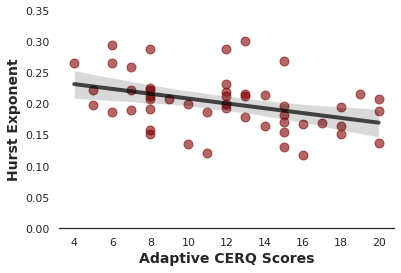

In [ ]:
#plot the relationship between HE of the vlPFC and phenotypic measures

fig, axs = plt.subplots(figsize=(6,4))

sns.set(style = 'white')
sns.regplot(x = demographics_df['adapCERQ'], y = demographics_df['HE_L_vlPFC'], ci = 95, scatter_kws = {"color": "maroon", "alpha":0.6, "s":80}, line_kws = {"color": "black", "alpha":0.7, "lw":4})
plt.xlabel('Adaptive CERQ Scores', fontweight ='bold', fontsize = 14)
plt.ylabel('Hurst Exponent',  fontweight ='bold', fontsize = 14)
sns.despine(left = True)
plt.ylim(0, 0.35)
#plt.xlim(0, 50)

plt.savefig('/content/drive/MyDrive/Year2/HE_hurst_adapCERQ_L_vlPFC.png')


In [ ]:
#compute the Hurst Exponent (HE) from a given timeseries at the network level

ventral_attention = [10, 12, 16, 52, 53, 54, 56, 57, 64, 65, 137, 140, 145, 148, 149, 150, 151, 153, 156, 162, 165, 183, 185, 186, 187, 190, 192, 194, 219]
dorsal_attention = [1, 4, 7, 8, 9, 14, 17, 19, 21, 22, 30, 31, 47, 48, 55, 70, 111, 112, 116, 139, 142, 143, 147, 154, 157, 164, 182, 184, 193, 196, 199, 242, 246, 247]
frontoparietal = [3, 5, 6, 13, 49, 50, 85, 86, 90, 96, 115, 134, 138, 141, 203, 222, 223, 225, 227, 239]
default_mode = [2, 11, 15, 18, 20, 28, 29, 32, 36, 44, 83, 88, 91, 93, 94, 95, 99, 101, 103, 104, 105, 106, 107, 108, 110, 113, 114, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 135, 136, 144, 146, 152, 155, 159, 178, 217, 220, 221, 224, 226, 229, 230, 231, 232, 233, 234, 236, 237, 238, 243, 244, 245, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268]
somatomotor = [23, 24, 25, 26, 27, 33, 34, 35, 37, 38, 39, 40, 45, 46, 51, 58, 60, 61, 62, 63, 84, 89, 92, 97, 109, 158, 159, 160, 161, 163, 166, 167, 168, 170, 171, 172, 173, 174, 179, 180, 181, 188, 189, 191, 195, 197, 202, 218, 228, 235]
limbic = [42, 68, 72, 75, 77, 79, 80, 82, 87, 98, 176, 198, 205, 207, 208, 211, 215, 216]
visual = [76, 78, 81, 100, 102, 212, 213, 214, 241]
subcortical =[41, 42, 59, 66, 67, 69, 71, 73, 74, 175, 177, 200, 201, 204, 206, 209, 210, 240]

HE_network = []
timeseries_Yeo7_Network = np.take(timeseries_array, np.array(subcortical) - 1, axis = 2)
timeseries_Yeo7_Network = np.mean(timeseries_Yeo7_Network, axis = 2)

for sub in range(timeseries_Yeo7_Network.shape[0]):

  H, c, val = compute_Hc(timeseries_Yeo7_Network[sub, :])
  HE_network.append(H)

print(HE_network)
np.savetxt('/content/drive/MyDrive/Year2/HE_hurst_subcortical.txt', HE_network)


[0.19374478236773743, 0.25237021352354244, 0.2380178263200517, 0.23098199665614924, 0.27723457595963974, 0.228532731924316, 0.36378465635888685, 0.2209839562945684, 0.27073791730017427, 0.25924702413594114, 0.1466386721853262, 0.2930497822895571, 0.17587337768100111, 0.21365784259512957, 0.27317193804468576, 0.18697888788232778, 0.2099564194567939, 0.3602608668787108, 0.25758560743146947, 0.25413084645886247, 0.1307695677544782, 0.21235612693996253, 0.21855298057535447, 0.11058069102298791, 0.23019003497926013, 0.32157509698222514, 0.14539845412360616, 0.24244828628870976, 0.15687996680715519, 0.22034000756879432, 0.2883000870942758, 0.2102947585400706, 0.19776453116986362, 0.29168458394565705, 0.19717607491471073, 0.26113578113065444, 0.26507020826603417, 0.24161338512899413, 0.2623524079110738, 0.17910823092897907, 0.1330269071907003, 0.2778439492432883, 0.27297906460134236, 0.2408428642476549, 0.18249437859643752, 0.22590579745022485, 0.24042574757247454, 0.21848069393762806, 0.2782

In [ ]:
#compute partial correlation using Spearman's Rank by including age as a covariate

demo = "/content/drive/MyDrive/Year2/demographics_HE_df.xlsx"
demographics_df = pd.read_excel(demo, sheet_name = 'demographics_hurst_networks_HE')

pg.partial_corr(data = demographics_df, x = 'BDI', y = 'VAN', covar = ['Age'], method = 'spearman')


In [ ]:
#apply FDR correction to adjust the p values for multiple comparisons across the networks

HE_BDI = [0.0019, 0.13, 0.83, 0.93, 0.28, 0.98, 0.54, 0.16]
HE_adapCERQ = [0.022, 0.32, 0.44, 0.71, 0.16, 0.65, 0.80, 0.22]
HE_maladapCERQ = [0.0071, 0.28, 0.65, 0.69, 0.73, 0.37, 0.39, 0.076]

import statsmodels as sm
sm.stats.multitest.fdrcorrection(HE_BDI, alpha = 0.05, method = 'i', is_sorted = False)


(array([ True, False, False, False, False, False, False, False]),
 array([0.0152    , 0.42666667, 0.98      , 0.98      , 0.56      ,
        0.98      , 0.864     , 0.42666667]))

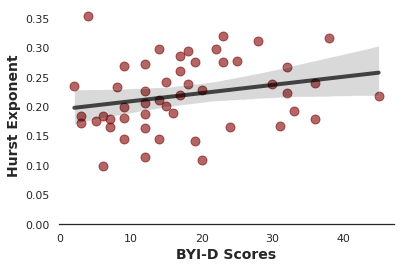

In [ ]:
#plot the relationship between HE of the ventral attention network and phenotypic measures

fig, axs = plt.subplots(figsize=(6,4))

sns.set(style = 'white')
sns.regplot(x = demographics_df['BDI'], y = demographics_df['VAN'], ci = 95, scatter_kws = {"color": "maroon", "alpha":0.6, "s":80}, line_kws = {"color": "black", "alpha":0.7, "lw":4})
plt.xlabel('BYI-D Scores', fontweight ='bold', fontsize = 14)
plt.ylabel('Hurst Exponent',  fontweight ='bold', fontsize = 14)
sns.despine(left = True)
plt.ylim(0, 0.37)
#plt.xlim(0, 50)

plt.savefig('/content/drive/MyDrive/Year2/HE_hurst_BDI_VAN.png')


## Intersubject Correlation (ISC) Analysis

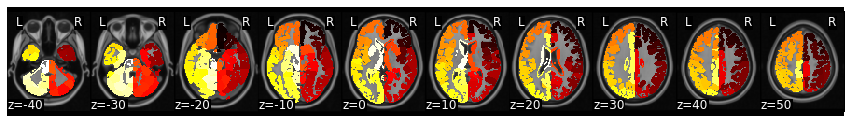

In [ ]:
#load the Shen 268 parcellation as a mask

mask = Brain_Data('https://neurovault.org/media/images/8423/shen_2mm_268_parcellation.nii.gz')
#mask = Brain_Data('/content/drive/MyDrive/Year2/Schaefer2018_1000Parcels_17Networks_order_FSLMNI152_2mm.nii')
mask_x = expand_mask(mask)
mask.plot()


0         1         2         3         4         5         6   \
0 -0.342904  0.311811  0.886840  0.066535 -0.572834  0.299703  0.009951   
1 -0.960098 -0.831805  0.596688 -0.140318 -0.542006  1.422322  0.102692   
2 -1.340571 -2.037369 -0.319739 -0.668632 -0.537484  2.034485  0.042362   
3 -1.185678 -2.299368 -1.583373 -1.142937 -0.559650  1.333476 -0.106494   
4 -0.490679 -1.459345 -2.383255 -0.993412 -0.430884 -0.368751 -0.313938   

         7         8         9   ...        40        41        42        43  \
0 -1.169047 -1.186667 -0.291296  ... -0.605787  0.395502  0.642508  3.124291   
1 -1.054983 -1.420008 -0.219720  ... -0.028031 -0.068188  1.608340  2.597335   
2 -0.528571 -0.514611  0.228639  ...  0.566424 -0.541514  2.347890  0.455417   
3 -0.067099  1.040821  0.599956  ...  0.714485 -0.174965  2.272420 -1.381947   
4  0.113889  2.023272  0.462921  ...  0.459272  0.997345  1.301899 -1.291580   

         44        45        46        47        48        49  
0 -0.943212 -0.235748  0.119053  0.151869  0.188121  0.780839  
1 -0.891003 -1.350341  1.209829  0.712014  0.213258  0.558987  
2 -0.135200 -1.503703  1.296603  0.636685 -0.323115 -0.001820  
3  0.879640 -0.610782 -0.065630 -0.033313 -0.929167 -0.834711  
4  1.473060  0.312112 -1.869662 -0.497850 -0.972458 -1.636173  

[5 rows x 50 columns]

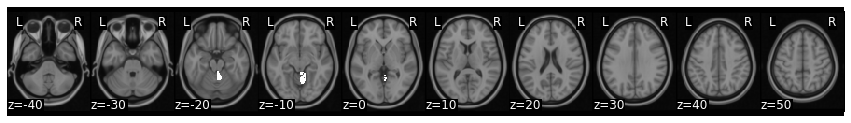

In [ ]:
#extract the subject-wise timeseries for each ROI

roi = 100
mask_x[roi].plot()

def get_subject_roi(data, roi):

    sub_rois = {}

    for sub in data:
        sub_rois[sub] = data[sub].iloc[:, roi]
    return pd.DataFrame(sub_rois)

sub_rois = get_subject_roi(timeseries_reg, roi)
sub_rois.head()


In [ ]:
#compute ISC for only one ROI using the subject-wise bootstrap method set at 5K iterations

stats_boot = isc(sub_rois, method = 'bootstrap', n_bootstraps = 5000, return_bootstraps = True)
print(f"ISC: {stats_boot['isc']:.03}, p = {stats_boot['p']:.04}")


ISC: 0.00458, p = 0.5157


In [ ]:
#compute ISC across the whole-brain (i.e. for 268 ROIs) using the subject-wise bootstrap method set at 5K iterations

isc_r, isc_p = {}, {}

for roi in range(timeseries_3D.shape[2]):
    
    stats = isc(get_subject_roi(timeseries_reg, roi), n_bootstraps = 5000, metric = 'mean', method = 'bootstrap')
    isc_r[roi], isc_p[roi] = stats['isc'], stats['p']
    
isc_r_brain, isc_p_brain = roi_to_brain(pd.Series(isc_r), mask_x), roi_to_brain(pd.Series(isc_p), mask_x)


In [ ]:
test = np.array(list(isc_p.values()))

import statsmodels as sm
test2 = sm.stats.multitest.fdrcorrection(test, alpha = 0.05, method = 'i', is_sorted = False)

### Network-level ISC

In [ ]:
network = pd.read_csv('/content/drive/MyDrive/Year2/network_4.csv')

pg.homoscedasticity(network, dv = 'ISC', group = 'Network')
model = ols('ISC ~ Network', data = network).fit()
shapiro(model.resid)


In [ ]:
pg.kruskal(data = network, dv = 'ISC', between = 'Network')


Source  ddof1           H         p-unc
Kruskal  Network      8  118.159649  7.949827e-22

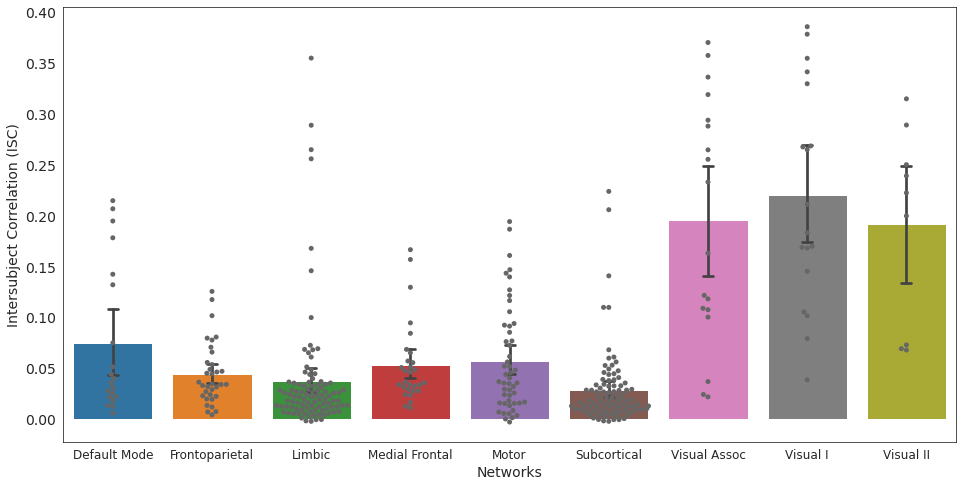

In [ ]:
plt.figure(figsize=(16, 8))

sns.set_style("white")
sns.swarmplot(x = 'Network', y = 'ISC', data = network, size = 5, color = ".4")
sns.barplot(x = 'Network', y = 'ISC', data = network, ci = 95, linewidth = 1, capsize = 0.1)

plt.xlabel('Networks', size = 14)
plt.ylabel('Intersubject Correlation (ISC)', size = 14)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ('Default Mode', 'Frontoparietal', 'Limbic', 'Medial Frontal', 'Motor', 'Subcortical', 'Visual Assoc', 'Visual I', 'Visual II'), size = 12) 
plt.yticks(size = 14) 


In [ ]:
cluster = pd.read_csv('/content/drive/MyDrive/Year2/cog_int_aff_clusters.csv')

pg.homoscedasticity(cluster, dv = 'ISC', group = 'Cluster')
model = ols('ISC ~ Cluster', data = cluster).fit()
shapiro(model.resid)


(0.7658834457397461, 6.689032071197983e-22)

In [ ]:
pg.kruskal(data = cluster, dv = 'ISC', between = 'Cluster')


Source  ddof1        H     p-unc
Kruskal  Cluster      2  0.09196  0.955061

(array([0, 1, 2]), <a list of 3 Text major ticklabel objects>)

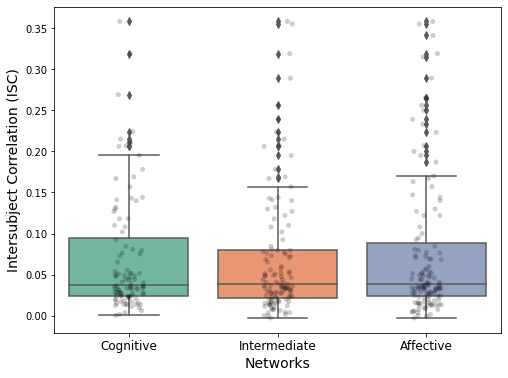

In [ ]:
plt.figure(figsize=(8, 6))

boxplot = sns.boxplot(x = "Cluster", y = "ISC", data = cluster, palette = 'Set2')
boxplot = sns.stripplot(x = "Cluster", y = "ISC", data = cluster, marker = "o", alpha = 0.2, color = 'black')

boxplot.set_xlabel("Networks", fontsize = 14)
boxplot.set_ylabel("Intersubject Correlation (ISC)", fontsize = 14)
plt.xticks(size = 12)


In [ ]:
valence = pd.read_csv('/content/drive/MyDrive/Year2/emotion_valence.csv')

pg.homoscedasticity(valence, dv = 'ISC', group = 'Valence')
model = ols('ISC ~ Valence', data = valence).fit()
shapiro(model.resid)


(0.7574694752693176, 9.840474633756157e-33)

In [ ]:
pg.kruskal(data = valence, dv = 'ISC', between = 'Valence')


Source  ddof1         H     p-unc
Kruskal  Valence      2  0.139115  0.932807

### Visualise ISC after applying FDR corrections

/usr/local/lib/python3.7/dist-packages/nilearn/plotting/html_stat_map.py:217: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  bg_img = load_mni152_template()



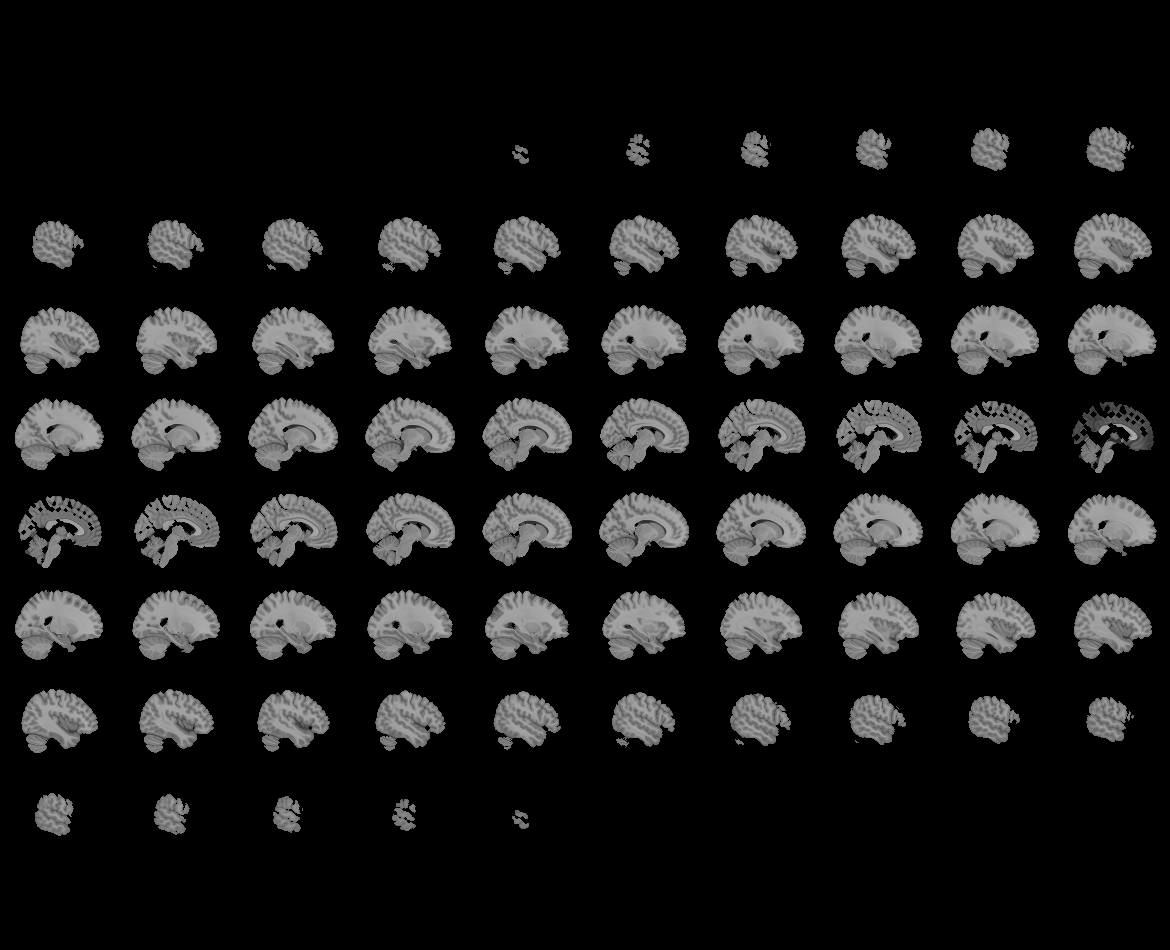
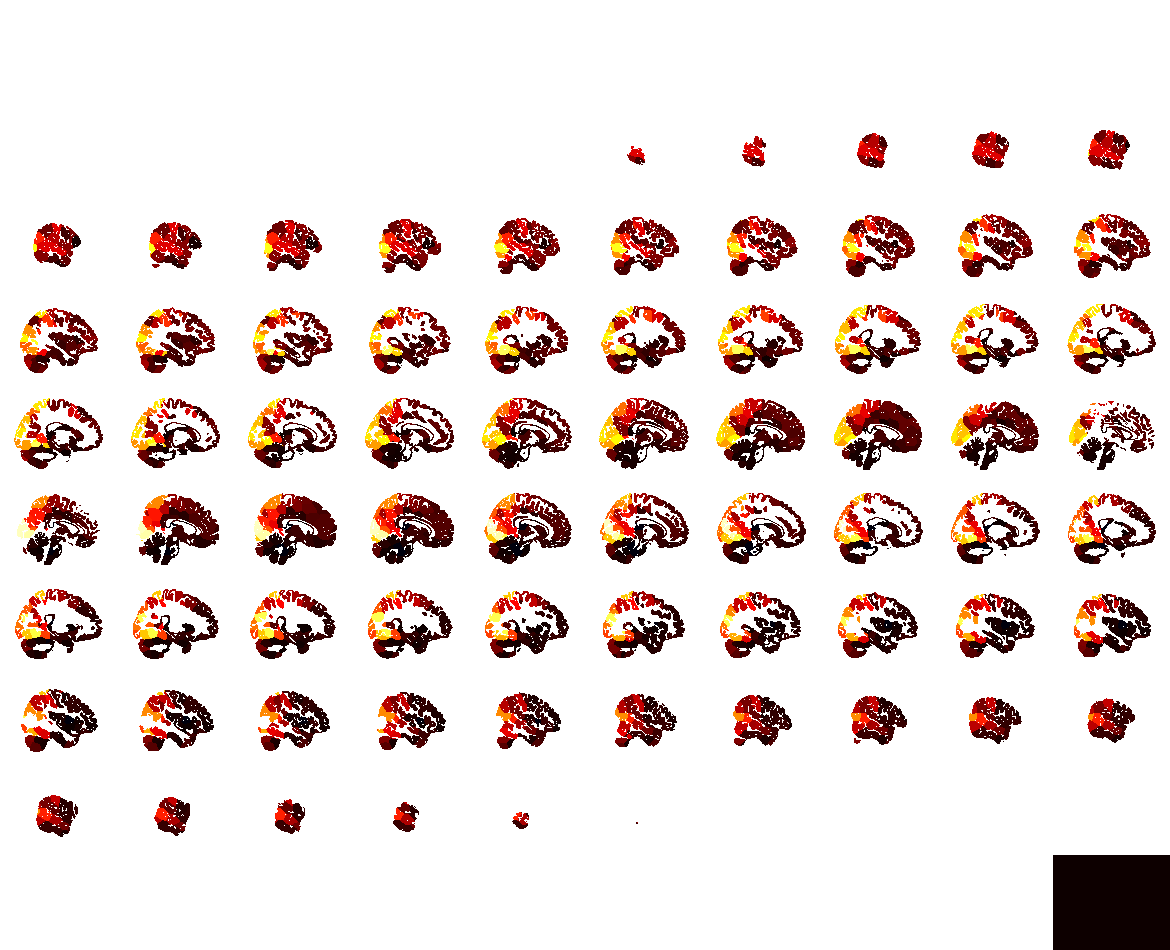

In [ ]:
view_img(isc_r_brain.to_nifti())


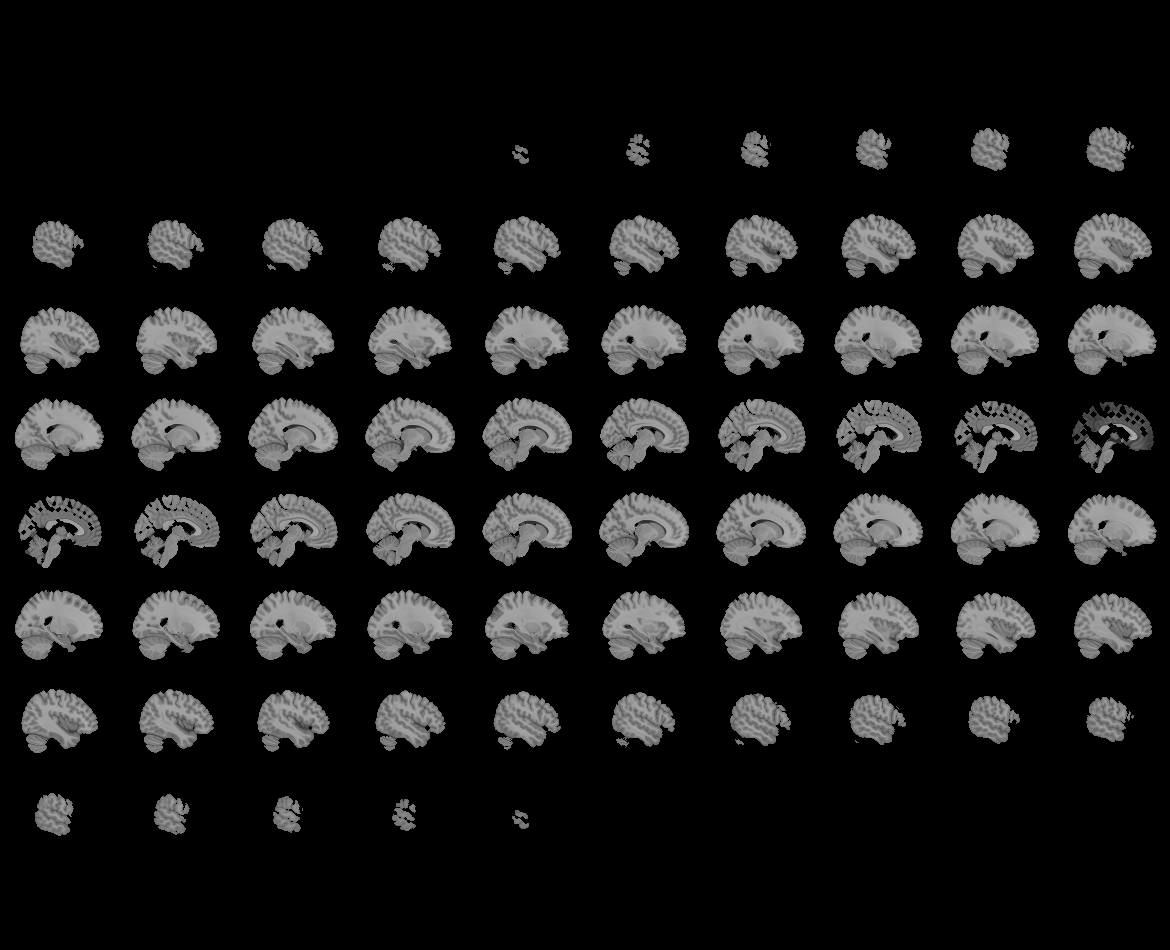
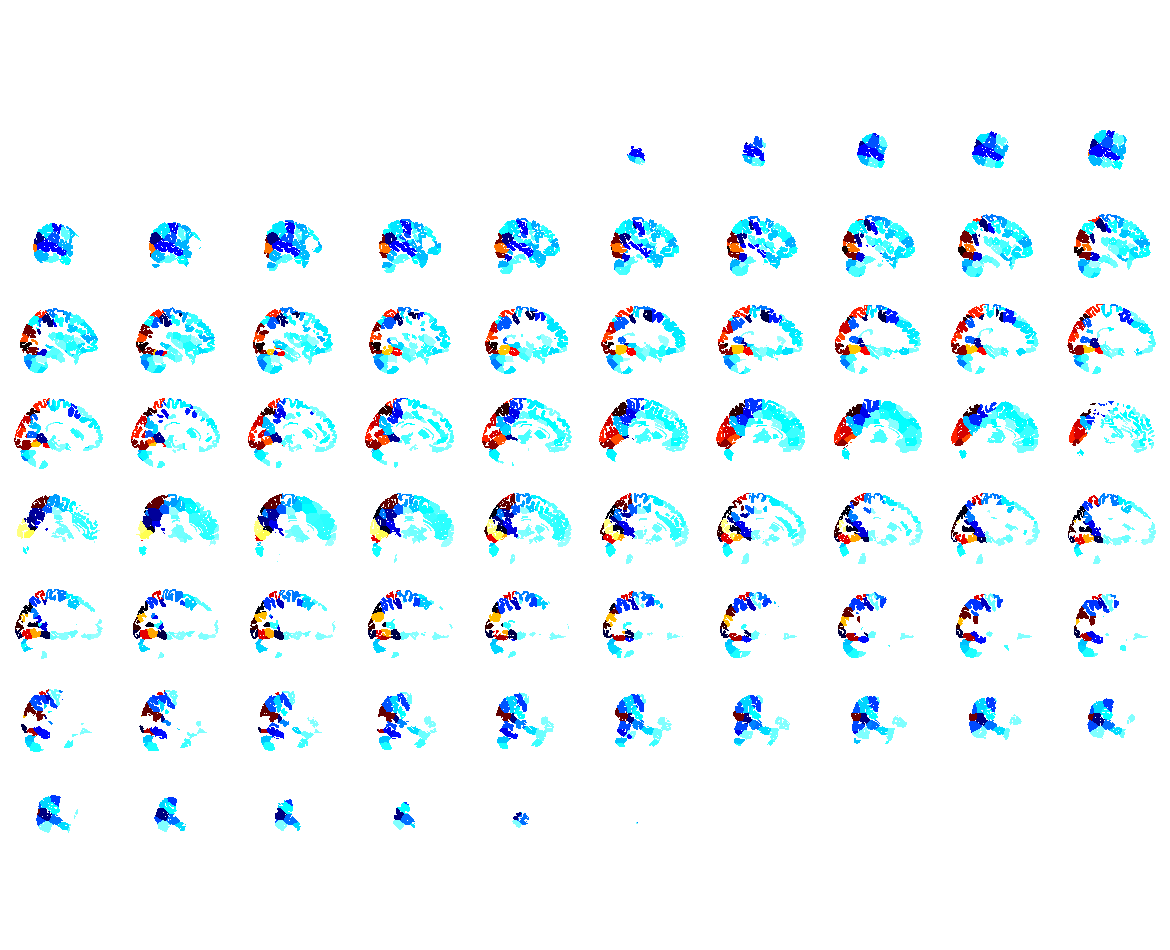

In [ ]:
view_img(threshold(isc_r_brain, isc_p_brain, thr = fdr(isc_p_brain.data)).to_nifti(), symmetric_cmap=False)

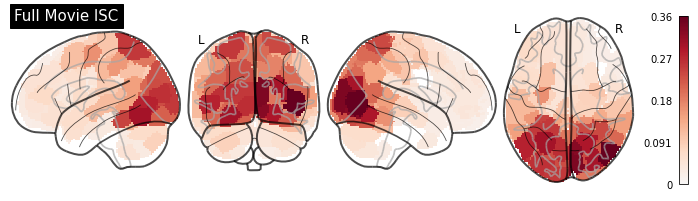

In [ ]:
plotting.plot_glass_brain(threshold(isc_r_brain, isc_p_brain, thr = fdr(isc_p_brain.data)).to_nifti(), colorbar = True, plot_abs = False, display_mode = 'lyrz', cmap = 'RdBu_r', title = 'Full Movie ISC')


In [ ]:
#count parcels that survive FDR correction
np.sum(pd.Series(isc_p).values <= fdr(isc_p_brain.data))


176

### Compute similarity matrices between pairs of participants

In [ ]:
timeseries_ISRA = []

for sub in range(len(sub_list)):

  timeseries_ISRA_to_array = timeseries_reg[sub].to_numpy()
  timeseries_ISRA.append(timeseries_ISRA_to_array)

timeseries_ISRA = np.array(timeseries_ISRA)

n_subs, n_ts, n_nodes = timeseries_ISRA.shape


In [ ]:
#compute the similarity matrices using adjacency matrices between pairs of participants

similarity_matrices = []

for node in range(n_nodes):
  
  similarity_matrices.append(Adjacency(1 - pairwise_distances(timeseries_ISRA[:, :, node], metric = 'correlation'), matrix_type = 'similarity'))

similarity_matrices = Adjacency(similarity_matrices)


### Load the BDI-Y and CERQ scores

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


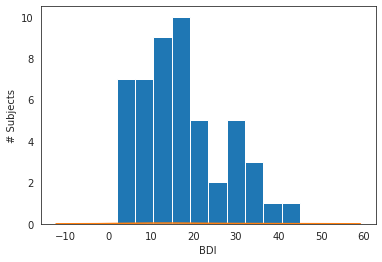

In [ ]:
#load the behavioural measures: (1) BDI-Y which assessed the severity of depressive symptoms in youths - (2) CERQ which measured the cognitive emotional regulation in adolescents

behav_data_BDI = pd.read_csv('/content/drive/MyDrive/Year2/behav_narsad_data.csv')
behav_data_CERQ = pd.read_csv('/content/drive/MyDrive/Year2/maladaptive_strategy_CERQ.csv')

behav = behav_data_BDI["BDI"]
plt.hist(behav)
plt.xlabel('BDI-Y Scores')
plt.ylabel('# Subjects')
sns.distplot(behav)

behav_rank = rankdata(behav)


### Compute the relationship between mean ISC and behavioural scores

In [ ]:
#compute the relationship between mean ISC and behavioural measures with Spearman's Rank using the permutation method set at 5K iterations

mean_roi_isc = np.zeros((n_nodes, n_subs))

mean_roi_isc_r = {}
mean_roi_isc_p = {}
perm_dis = {}

for node in range(len(similarity_matrices)):

  pairwise_sim_matrix = similarity_matrices[node].squareform()
  
  for sub in range(n_subs):

    corr_matrix = pairwise_sim_matrix[sub, :]
    corr_matrix_nondiag = np.delete(corr_matrix, sub)
    mean_roi_isc[node, sub] = np.mean(corr_matrix_nondiag)

for node in range(mean_roi_isc.shape[0]):

  stats = correlation_permutation(mean_roi_isc[node, :], behav, method = 'permute', n_permute = 5000, metric = 'spearman', n_jobs = -1, return_perms = True, random_state = None)
  mean_roi_isc_r[node], mean_roi_isc_p[node] = stats['correlation'], stats['p']
  perm_dis[node] = stats['perm_dist']

mean_roi_isc_r_brain, mean_roi_isc_p_brain = roi_to_brain(pd.Series(mean_roi_isc_r), mask_x), roi_to_brain(pd.Series(mean_roi_isc_p), mask_x)


### Display null distribution and observed mean (Sperman's Rank) correlation

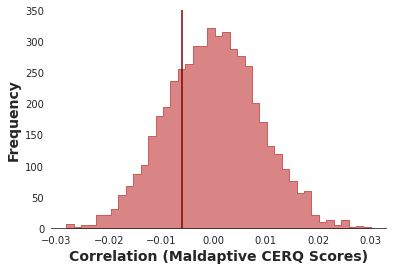

In [ ]:
#display the null distribution from the permutation tests and observed mean correlation (Spearman's Rank) across 268 parcels

perm_array = np.array(list(perm_dis.values()))
mean_perm = np.mean(perm_array, axis = 0)
sns.histplot(mean_perm, element="step", color = 'indianred')

plt.axvline(-0.006, color = 'maroon', linestyle = '-');
plt.ylabel('Frequency', fontweight ='bold', fontsize = 14)
plt.xlabel('Correlation (Maldaptive CERQ Scores)', fontweight ='bold', fontsize = 14)

plt.ylim(0, 350)
sns.set_style("white")
sns.despine(left=True)

plt.savefig('/content/drive/MyDrive/Year2/ISC_maladapCERQ_Null_Distribution_fullmovie.png')


In [ ]:
np.mean(np.array(list(mean_roi_isc_r.values())))

-0.005597017776862133

In [ ]:
#compute significance of the observed mean correlation (Spearman's Rank) as described in Gruskin et al. (2020)

isc_r_array = np.array(list(mean_roi_isc_r.values()))
mean_isc_r = np.mean(isc_r_array)
p_val = (2 + np.sum(mean_perm <= mean_isc_r)) / 5002


### Visualising the relationship between mean ISC and BDI-Y

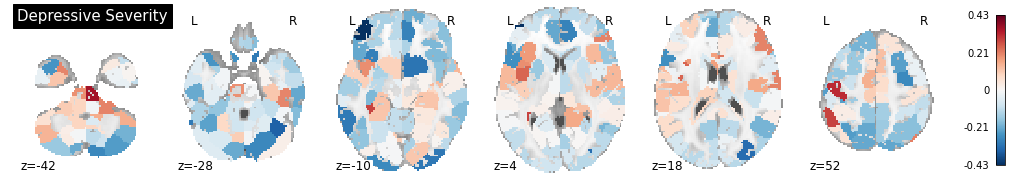

In [ ]:
plot_stat_map(mean_roi_isc_r_brain.to_nifti(), display_mode = 'z', cut_coords = 6, title = "Depressive Severity", cmap = 'RdBu_r')

In [ ]:
fdr_thr = fdr(pd.Series(mean_roi_isc_p).values)
fdr_thr


In [ ]:
test = pd.Series(mean_roi_isc_p).values <= 0.0001999600079984003
np.where(test == True)


(array([ 90, 101, 102, 104, 105, 612]),)

In [ ]:
import statsmodels as sm
sm.stats.multitest.fdrcorrection(pd.Series(mean_roi_isc_p).values, alpha = 0.05, method = 'indep', is_sorted = False)


In [ ]:
fdr_thr = fdr(pd.Series(mean_roi_isc_p).values)
plot_stat_map(threshold(mean_roi_isc_r_brain, mean_roi_isc_p_brain, thr = fdr_thr).to_nifti(), display_mode = 'z', cut_coords = 6, title = "Depressive Severity", cmap = 'RdBu_r')


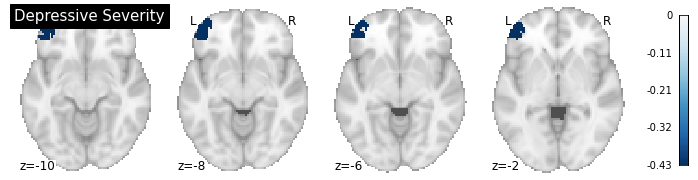

In [ ]:
plot_stat_map(threshold(mean_roi_isc_r_brain, mean_roi_isc_p_brain, thr = 0.01).to_nifti(), display_mode = 'z', cut_coords = 4, title = "Depressive Severity", cmap = 'RdBu_r')

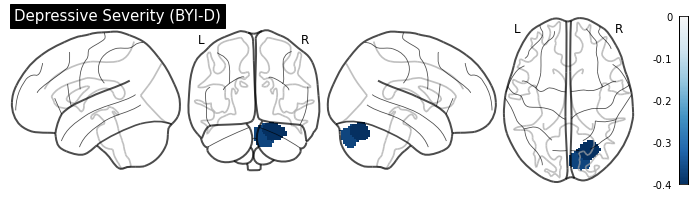

In [ ]:
plotting.plot_glass_brain(threshold(mean_roi_isc_r_brain, mean_roi_isc_p_brain, thr = 0.01).to_nifti(), colorbar = True, plot_abs = False, title = "Depressive Severity (BYI-D)", display_mode = 'lyrz', cmap = 'RdBu_r')


In [ ]:
test = pd.Series(mean_roi_isc_p).values <= 0.01
np.where(test == True)


(array([110, 113]),)

In [ ]:
test = pd.Series(mean_roi_isc_r).values
test[142]

-0.42777840222357005


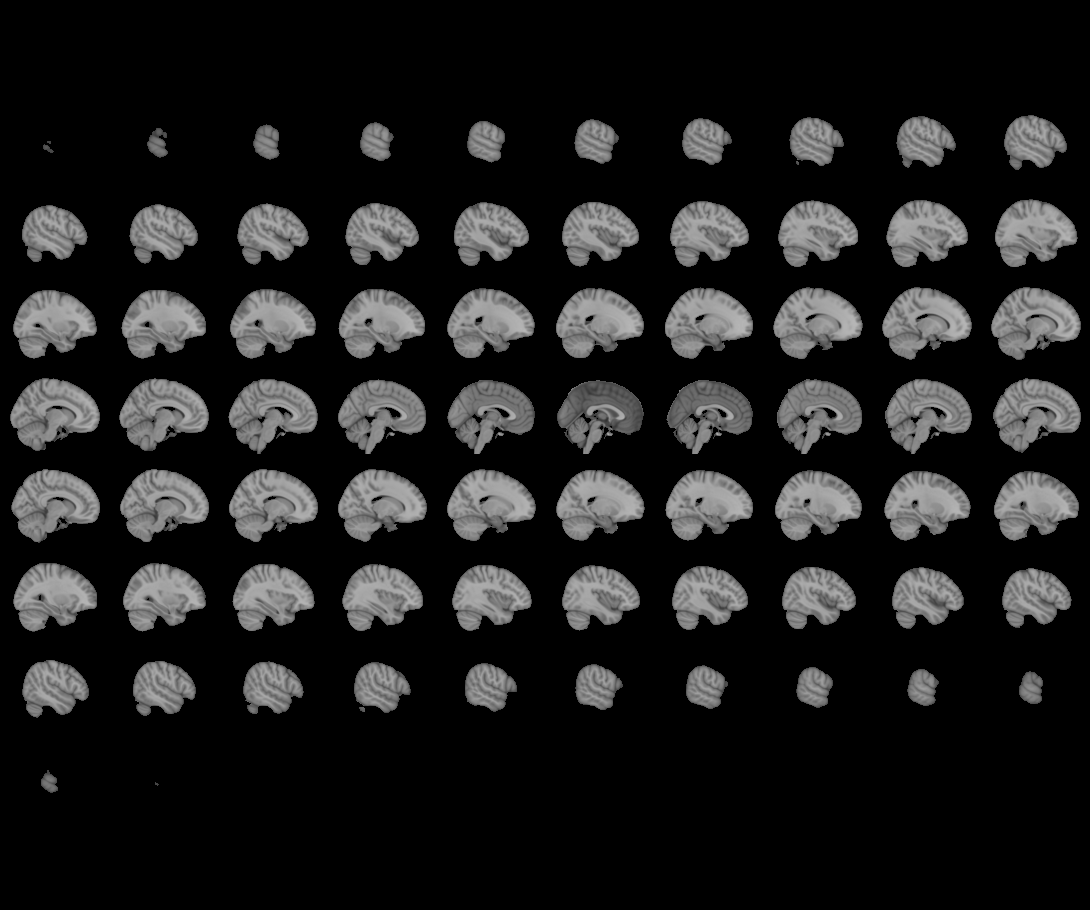
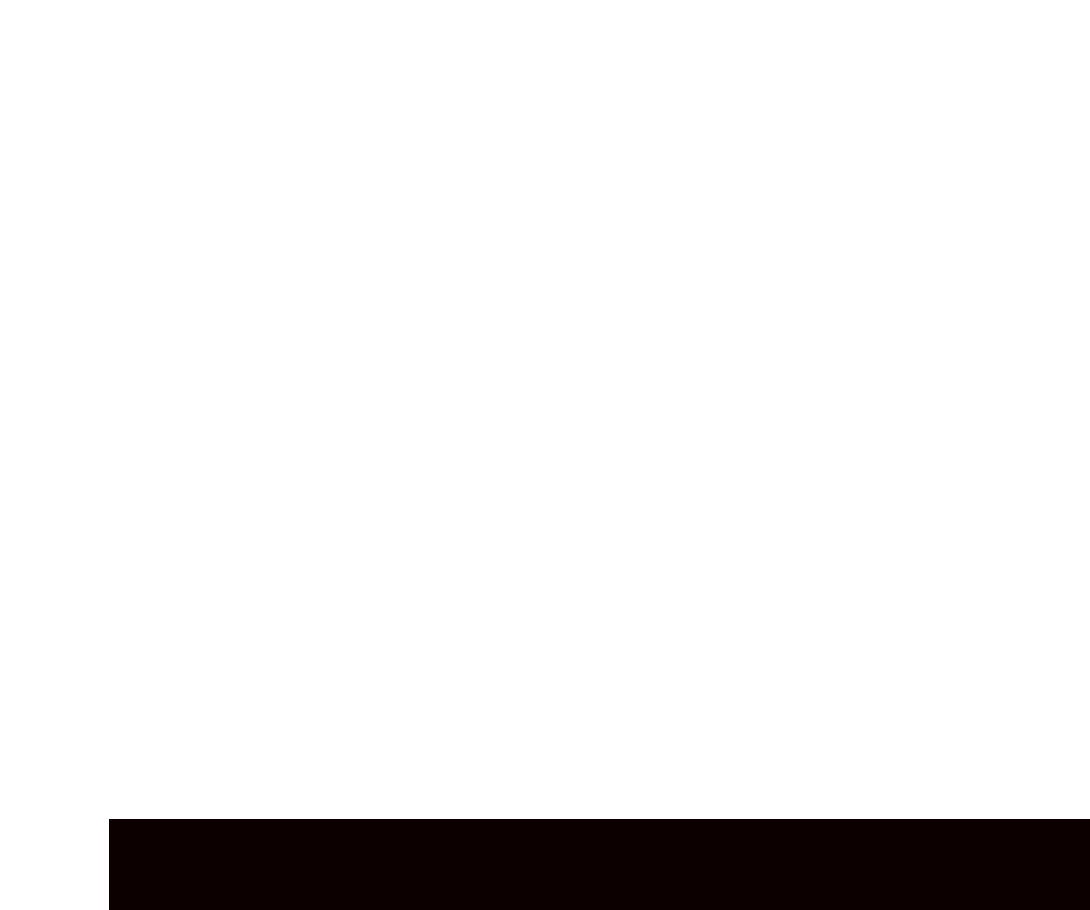

In [ ]:
view_img(threshold(mean_roi_isc_r_brain, mean_roi_isc_p_brain, thr = 0.01).to_nifti())

### Visualising the relationship between mean ISC and CERQ

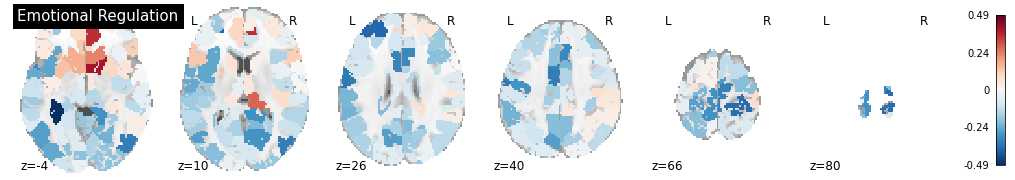

In [ ]:
plot_stat_map(mean_roi_isc_r_brain.to_nifti(), display_mode = 'z', cut_coords = 6, title = "Emotional Regulation", cmap = 'RdBu_r')

In [ ]:
fdr_thr = fdr(pd.Series(mean_roi_isc_p).values)
plot_stat_map(threshold(mean_roi_isc_r_brain, mean_roi_isc_p_brain, thr = fdr_thr).to_nifti(), display_mode = 'z', cut_coords = 6, title = "Emotional Regulation", cmap = 'RdBu_r')


In [ ]:
fdr_thr = fdr(pd.Series(mean_roi_isc_p).values)
fdr_thr

In [ ]:
test = pd.Series(mean_roi_isc_p).values <= 0.0001999600079984003
np.where(test == True)

(array([ 90, 101, 102, 104, 105, 612]),)

In [ ]:
import statsmodels as sm
sm.stats.multitest.fdrcorrection(pd.Series(mean_roi_isc_p).values, alpha = 0.05, method = 'indep', is_sorted = False)


In [ ]:
plot_stat_map(threshold(mean_roi_isc_r_brain, mean_roi_isc_p_brain, thr = 0.01).to_nifti(), display_mode = 'z', cut_coords = 4, title = "Emotional Regulation", cmap = 'RdBu_r')

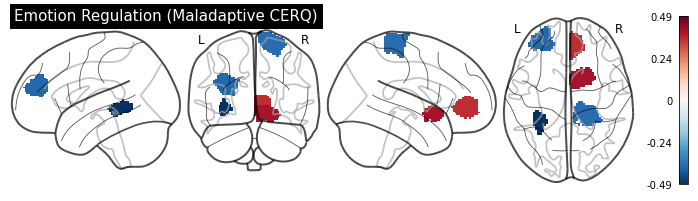

In [ ]:
plotting.plot_glass_brain(threshold(mean_roi_isc_r_brain, mean_roi_isc_p_brain, thr = 0.01).to_nifti(), colorbar = True, plot_abs = False, title = 'Emotion Regulation (Maladaptive CERQ)', display_mode = 'lyrz', cmap = 'RdBu_r')


In [ ]:
test = pd.Series(mean_roi_isc_p).values <= 0.01
np.where(test == True)

(array([  4,  38, 124, 143, 229]),)

In [ ]:
test = pd.Series(mean_roi_isc_r).values
test[143]

-0.3798421984972627


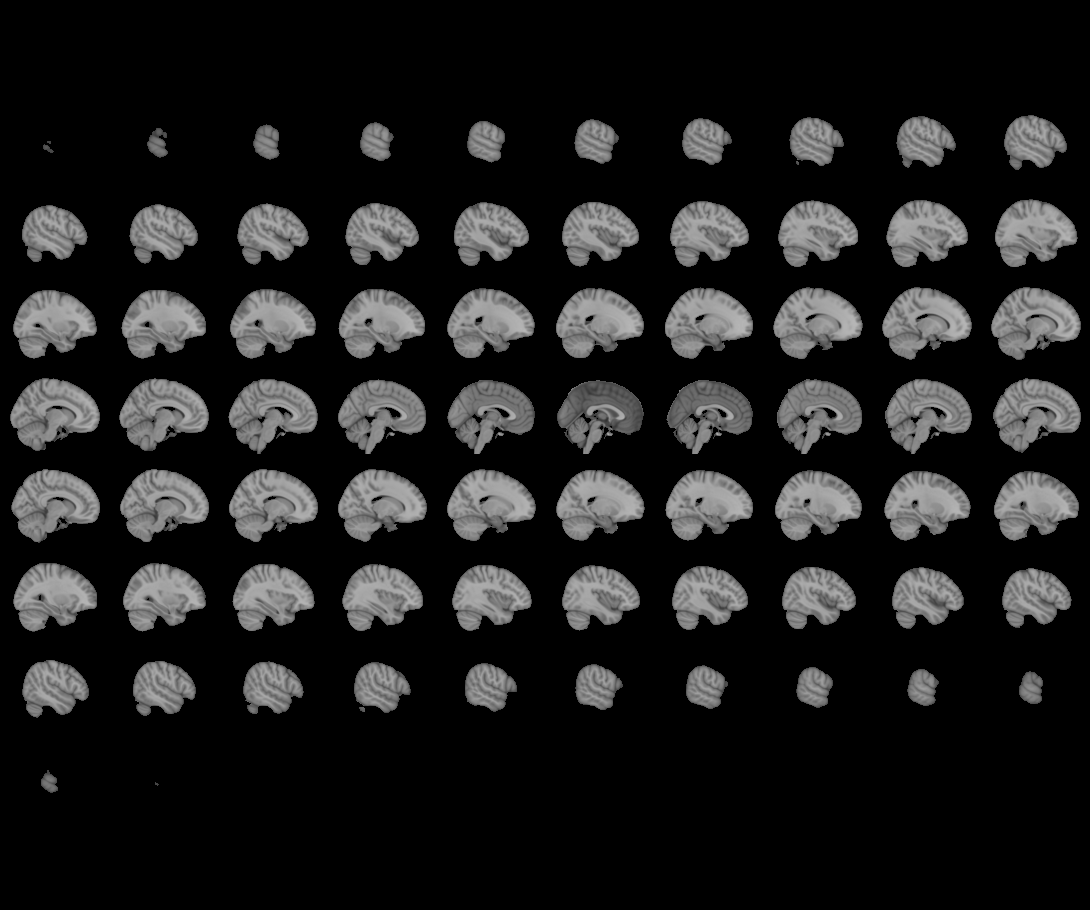
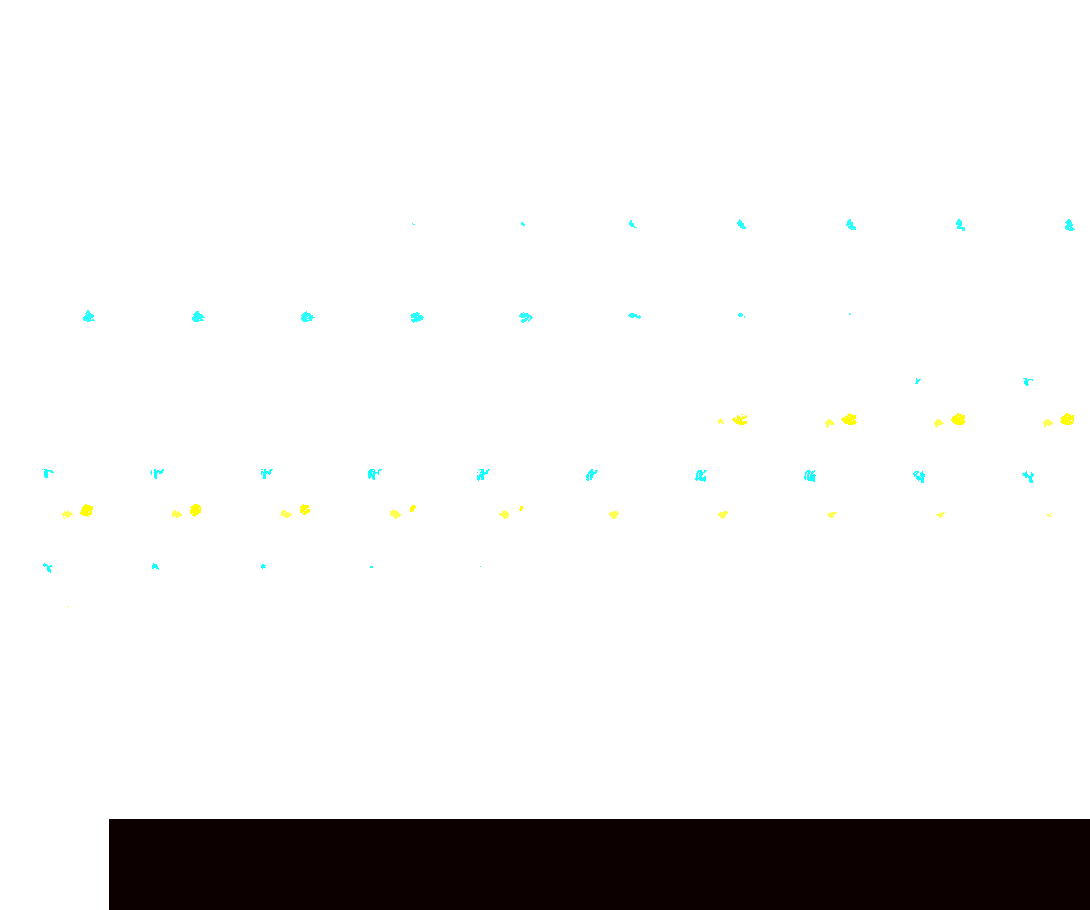

In [ ]:
view_img(threshold(mean_roi_isc_r_brain, mean_roi_isc_p_brain, thr = 0.01).to_nifti())

Comparing the mean ISC Distribution with the Null Distribution for BDI-Y and CERQ

Text(0.2, 40, 't=-2.95, p = 0.003')

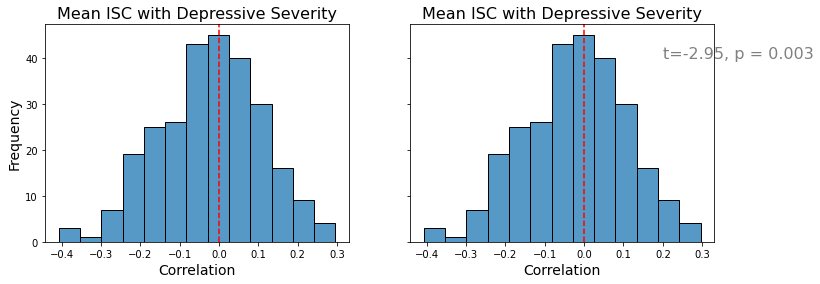

In [ ]:
f, a = plt.subplots(ncols = 2, figsize = (12,4), sharex = True, sharey = True)

sns.histplot(list(mean_roi_isc_r.values()), ax = a[0])
a[0].axvline(0, color = 'red', linestyle = '--');
a[0].set_ylabel('Frequency', fontsize = 14)
a[0].set_xlabel('Correlation', fontsize = 14)
a[0].set_title('Mean ISC with Depressive Severity', fontsize = 16)
t, p = ttest_1samp(list(mean_roi_isc_r.values()), 0)
a[0].annotate(f't={t:.2f}, p = {p:.03f}', xy = (.2, 40),fontsize = 16, color = 'white')

sns.histplot(list(mean_roi_isc_r.values()), ax = a[1])
a[1].axvline(0, color = 'red', linestyle = '--');
a[1].set_ylabel('Frequency', fontsize = 14)
a[1].set_xlabel('Correlation', fontsize = 14)
a[1].set_title('Mean ISC with Depressive Severity', fontsize = 16)
t, p = ttest_1samp(list(mean_roi_isc_r.values()), 0)
a[1].annotate(f't={t:.2f}, p = {p:.03f}', xy = (.2, 40),fontsize = 16, color = 'gray')

## ISC Analysis with FC Networks

In [ ]:
#load the positive FC network as a mask
mask = Brain_Data('/content/drive/MyDrive/Year2/shen_emo_pos_network.nii.gz')
mask_x = expand_mask(mask)
mask.plot()


In [ ]:
rois = ['R_Amyg', 'L_Amyg', 'R_OFC', 'L_vlPFC', 'L_dlPMC', 'L_dlPFC', 'R_dlPFC', 'R_aPFC', 'L_rACC', 'L_aINS']
neurosynth = [99, 231, 18, 151, 162, 149, 14, 144, 219, 169]
neuro_roi_index = [98, 230, 17, 150, 161, 148, 13, 143, 218, 168]

pos_network = ['R_Amyg', 'L_Amyg', 'R_OFC', 'L_vlPFC', 'L_aINS']
pos_net_index = [98, 230, 17, 150, 168]

neg_network = ['L_dlPFC', 'R_dlPFC', 'R_aPFC', 'L_rACC']
neg_net_index = [148, 13, 143, 218]

timeseries_neurosynth = np.take(timeseries_array, pos_net_index, axis = 2)

timeseries_reg_neurosynth = {}

for sub in range(timeseries_neurosynth.shape[0]):

  timeseries_reg_neurosynth[sub] = pd.DataFrame(timeseries_neurosynth[sub, :, :])


In [ ]:
#compute ISC across the positive FC network using the subject-wise bootstrap method set at 5K iterations

isc_r, isc_p = {}, {}

for roi in range(timeseries_neurosynth.shape[2]):

    stats = isc(get_subject_roi(timeseries_reg_neurosynth, roi), n_bootstraps = 5000, metric = 'median', method = 'bootstrap')
    isc_r[roi], isc_p[roi] = stats['isc'], stats['p']
    
isc_r_brain, isc_p_brain = roi_to_brain(pd.Series(isc_r), mask_x), roi_to_brain(pd.Series(isc_p), mask_x)


In [ ]:
timeseries_pos_ISRA = []

for sub in range(len(sub_list)):

  timeseries_pos_to_array = timeseries_reg_neurosynth[sub].to_numpy()
  timeseries_pos_ISRA.append(timeseries_pos_to_array)

timeseries_pos_ISRA = np.array(timeseries_pos_ISRA)

n_subs, n_ts, n_nodes = timeseries_pos_ISRA.shape


In [ ]:
similarity_matrices = []

for node in range(n_nodes):

    similarity_matrices.append(Adjacency(1 - pairwise_distances(timeseries_pos_ISRA[:, :, node], metric='correlation'), matrix_type='similarity'))

similarity_matrices = Adjacency(similarity_matrices)


In [ ]:
#compute the relationship between mean ISC and behavioural measures with Spearman's Rank using the permutation method set at 5K iterations

mean_roi_isc = np.zeros((n_nodes, n_subs))

mean_roi_isc_r = {}
mean_roi_isc_p = {}

for node in range(len(similarity_matrices)):

  pairwise_sim_matrix = similarity_matrices[node].squareform()
  
  for sub in range(n_subs):

    corr_matrix = pairwise_sim_matrix[sub, :]
    corr_matrix_nondiag = np.delete(corr_matrix, sub)
    mean_roi_isc[node, sub] = np.mean(corr_matrix_nondiag)

for node in range(mean_roi_isc.shape[0]):

  stats = correlation_permutation(mean_roi_isc[node, :], behav, method = 'permute', n_permute = 5000, metric = 'spearman', n_jobs = -1, return_perms = False, random_state = None)
  mean_roi_isc_r[node], mean_roi_isc_p[node] = stats['correlation'], stats['p']

mean_roi_isc_r_brain, mean_roi_isc_p_brain = roi_to_brain(pd.Series(mean_roi_isc_r), mask_x), roi_to_brain(pd.Series(mean_roi_isc_p), mask_x)


## Intersubject Representational Similarity Analysis (IS-RSA)

In [ ]:
def sort_square_mtx(mtx, vct):
    """
    Sorts rows/columns of a matrix according to a separate vector.
    """
    
    inds = vct.argsort()
    mtx_sorted = mtx.copy()
    mtx_sorted = mtx_sorted[inds, :]
    mtx_sorted = mtx_sorted[:, inds]
    
    return mtx_sorted

def scale_mtx(mtx):
    """
    Scales a matrix to have values between 0 and 1.
    """
    return (mtx-np.min(mtx))/(np.max(mtx)-np.min(mtx))
    

### Compute behavioural similarity matrix using Euclidean distance for BDI-Y

In [ ]:
#compute behavioural similarity matrix using Euclidean distance for BDI-Y scores

behav_nn_BDI = Adjacency(pairwise_distances(np.reshape(behav_rank, (-1, 1)), metric = 'euclidean'), matrix_type = 'distance')
behav_nn_BDI = behav_nn_BDI.distance_to_similarity()

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (13,5))
behav_nn_BDI.plot(axes = ax1)
ax1.set_title("Behavioural Similarity Matrix (before sorting)", fontsize = 14)
ax1.set_ylabel('Subject', fontsize = 14)
ax1.set_xlabel('Subject', fontsize = 14)
ax1.set_xticks([])
ax1.set_yticks([])

sns.heatmap(sort_square_mtx(behav_nn_BDI.squareform(), behav), ax = ax2, square = True, xticklabels = False, yticklabels = False)
ax2.set_title("Behavioural Similarity Matrix (after sorting)", fontsize = 14)
ax2.set_ylabel('Subject', fontsize = 14)
ax2.set_xlabel('Subject', fontsize = 14)


NameError: ignored

### Compute behavioural similarity matrix using Euclidean distance for CERQ

In [ ]:
#compute behavioural similarity matrix using Euclidean distance for CERQ scores

behav_nn_CERQ = Adjacency(pairwise_distances(np.reshape(behav_rank, (-1, 1)), metric = 'euclidean'), matrix_type = 'distance')
behav_nn_CERQ = behav_nn_CERQ.distance_to_similarity()

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (13,5))
behav_nn_CERQ.plot(axes = ax1)
ax1.set_title("Behavioural Similarity Matrix (before sorting)", fontsize = 14)
ax1.set_ylabel('Subject', fontsize = 14)
ax1.set_xlabel('Subject', fontsize = 14)
ax1.set_xticks([])
ax1.set_yticks([])

sns.heatmap(sort_square_mtx(behav_nn_CERQ.squareform(), behav), ax = ax2, square = True, xticklabels = False, yticklabels = False)
ax2.set_title("Behavioural Similarity Matrix (after sorting)", fontsize = 14)
ax2.set_ylabel('Subject', fontsize = 14)
ax2.set_xlabel('Subject', fontsize = 14)


### Compute behavioural similarity matrix using Anna Karenina distance for BDI-Y

In [ ]:
#compute behavioural similarity matrix using Anna Karenina distance for BDI-Y scores

behav_annak_BDI = np.zeros((n_subs, n_subs))

for i in range(n_subs):

    for j in range(n_subs):

        if i < j:

            sim_ij = np.mean([behav_rank[i], behav_rank[j]]) / n_subs
            behav_annak_BDI[i,j] = sim_ij
            behav_annak_BDI[j,i] = sim_ij
            
        elif i==j:

            behav_annak_BDI[i,j] = 1

behav_annak_BDI = Adjacency(behav_annak_BDI, matrix_type = 'similarity')

fig, (ax1, ax2) = plt.subplots(1,2, figsize =(13,5))
behav_annak_BDI.plot(axes = ax1)
ax1.set_title("Behavioral Similarity Matrix before sorting", fontsize = 14)
ax1.set_ylabel('Subject', fontsize = 14)
ax1.set_xlabel('Subject', fontsize = 14)
ax1.set_xticks([])
ax1.set_yticks([])

sns.heatmap(sort_square_mtx(behav_annak_BDI.squareform(), behav), ax = ax2, square = True, xticklabels = False, yticklabels = False)
ax2.set_title("Behavioral Similarity Matrix after sorting", fontsize = 14)
ax2.set_ylabel('Subject', fontsize = 14)
ax2.set_xlabel('Subject', fontsize = 14)


### Compute behavioural similarity matrix using Anna Karenina distance for CERQ

In [ ]:
#compute behavioural similarity matrix using Anna Karenina distance for CERQ scores

behav_annak_CERQ = np.zeros((n_subs, n_subs))

for i in range(n_subs):

    for j in range(n_subs):

        if i < j:

            sim_ij = np.mean([behav_rank[i], behav_rank[j]]) / n_subs
            behav_annak_CERQ[i,j] = sim_ij
            behav_annak_CERQ[j,i] = sim_ij
            
        elif i==j:

            behav_annak_CERQ[i,j] = 1

behav_annak_CERQ = Adjacency(behav_annak_CERQ, matrix_type = 'similarity')

fig, (ax1, ax2) = plt.subplots(1,2, figsize =(13,5))
behav_annak_CERQ.plot(axes = ax1)
ax1.set_title("Behavioral Similarity Matrix before sorting", fontsize = 14)
ax1.set_ylabel('Subject', fontsize = 14)
ax1.set_xlabel('Subject', fontsize = 14)
ax1.set_xticks([])
ax1.set_yticks([])

sns.heatmap(sort_square_mtx(behav_annak_CERQ.squareform(), behav), ax = ax2, square = True, xticklabels = False, yticklabels = False)
ax2.set_title("Behavioral Similarity Matrix after sorting", fontsize = 14)
ax2.set_ylabel('Subject', fontsize = 14)
ax2.set_xlabel('Subject', fontsize = 14)


In [ ]:
#compute brain similarity using ISRA

timeseries_ISRA = []

for sub in range(len(sub_list)):

  timeseries_ISRA_to_array = timeseries_reg[sub].to_numpy()
  timeseries_ISRA.append(timeseries_ISRA_to_array)

timeseries_ISRA = np.array(timeseries_ISRA)

n_subs, n_ts, n_nodes = timeseries_ISRA.shape


In [ ]:
similarity_matrices = []

for node in range(n_nodes):

    similarity_matrices.append(Adjacency(1 - pairwise_distances(timeseries_ISRA[:, :, node], metric='correlation'), matrix_type='similarity'))

similarity_matrices = Adjacency(similarity_matrices)


### Compute IRSA using Euclidean and Anna Karenina distances for BDI-Y

In [ ]:
#compute the IRSA for Euclidean and Anna Karenina distances with Spearman's Rank using the permutation method set at 5K iterations for BDI-Y scores

isrsa_nn_BDI = {}
isrsa_annak_BDI = {}

for node in range(len(similarity_matrices)):
  print(node)
  #isrsa_nn_BDI[node] = similarity_matrices[node].similarity(behav_nn_BDI, metric = 'spearman', n_permute = 5000, n_jobs = 1)['correlation']
  isrsa_annak_BDI[node] = similarity_matrices[node].similarity(behav_annak_BDI, metric = 'spearman', n_permute = 5000, n_jobs= 1)['correlation']

#isrsa_nn_BDI_brain = roi_to_brain(pd.Series(isrsa_nn_BDI), mask_x)
isrsa_annak_BDI_brain = roi_to_brain(pd.Series(isrsa_annak_BDI), mask_x)


### Compute IRSA using Euclidean and Anna Karenina distances for CERQ

In [ ]:
#compute the IRSA for Euclidean and Anna Karenina distances with Spearman's Rank using the permutation method set at 5K iterations for CERQ scores

isrsa_nn_CERQ = {}
isrsa_annak_CERQ = {}

for node in range(len(similarity_matrices)):
  
  #isrsa_nn_CERQ[node] = similarity_matrices[node].similarity(behav_nn_CERQ, metric = 'spearman', n_permute = 5000, n_jobs = 1)['correlation']
  isrsa_annak_CERQ[node] = similarity_matrices[node].similarity(behav_annak_CERQ, metric = 'spearman', n_permute = 5000, n_jobs= 1)['correlation']

#isrsa_nn_CERQ_brain = roi_to_brain(pd.Series(isrsa_nn_CERQ), mask_x)
isrsa_annak_CERQ_brain = roi_to_brain(pd.Series(isrsa_annak_CERQ), mask_x)


### Visualising the relationship between intersubject representational similarity and BDI-Y

In [ ]:
#vmax = np.max(np.abs([list(isrsa_nn_BDI.values()), list(isrsa_annak_BDI.values())]))
##plot_stat_map(isrsa_nn_BDI_brain.to_nifti(), display_mode = 'z', cut_coords = 6, vmax = vmax, title = "Euclidean", cmap = 'RdBu_r')
plot_stat_map(isrsa_annak_BDI_brain.to_nifti(), display_mode = 'z', cut_coords = 6, title = "AnnaK", cmap = 'RdBu_r')


### Visualising the relationship between intersubject representational similarity and CERQ

In [ ]:
vmax = np.max(np.abs([list(isrsa_nn_CERQ.values()), list(isrsa_annak_CERQ.values())]))
plot_stat_map(isrsa_nn_CERQ_brain.to_nifti(), display_mode = 'z', cut_coords = 6, vmax = vmax, title = "Euclidean", cmap = 'RdBu_r')
plot_stat_map(isrsa_annak_CERQ_brain.to_nifti(), display_mode = 'z', cut_coords = 6, vmax = vmax, title = "AnnaK", cmap = 'RdBu_r')


### Comparing the IS-RSA distribution to the Null distribution for BDI-Y

In [ ]:
f, a = plt.subplots(ncols = 2, figsize = (12,4), sharex = True, sharey = True)

sns.histplot(list(isrsa_nn_BDI.values()), ax = a[0])
a[0].axvline(0, color = 'red', linestyle = '--');
a[0].set_ylabel('Frequency', fontsize = 14)
a[0].set_xlabel('Correlation', fontsize = 14)
a[0].set_title('Euclidean Distance IS-RSA', fontsize = 16)
t, p = ttest_1samp(list(isrsa_nn_BDI.values()), 0)
a[0].annotate(f't={t:.2f}, p = {p:.03f}', xy = (.2, 40),fontsize = 16, color = 'gray')

sns.histplot(list(isrsa_annak_BDI.values()), ax = a[1])
a[1].axvline(0, color = 'red', linestyle = '--');
a[1].set_ylabel('Frequency', fontsize = 14)
a[1].set_xlabel('Correlation', fontsize = 14)
a[1].set_title('Anna Karenina Distance IS-RSA', fontsize = 16)
t, p = ttest_1samp(list(isrsa_annak_BDI.values()), 0)
a[1].annotate(f't={t:.2f}, p = {p:.03f}', xy = (.2, 40),fontsize = 16, color = 'gray')


### Comparing the IS-RSA distribution to the Null distribution for CERQ

In [ ]:
f, a = plt.subplots(ncols = 2, figsize = (12,4), sharex = True, sharey = True)

sns.histplot(list(isrsa_nn_CERQ.values()), ax = a[0])
a[0].axvline(0, color = 'red', linestyle = '--');
a[0].set_ylabel('Frequency', fontsize = 14)
a[0].set_xlabel('Correlation', fontsize = 14)
a[0].set_title('Euclidean Distance IS-RSA', fontsize = 16)
t, p = ttest_1samp(list(isrsa_nn_CERQ.values()), 0)
a[0].annotate(f't={t:.2f}, p = {p:.03f}', xy = (.2, 40),fontsize = 16, color = 'gray')

sns.histplot(list(isrsa_annak_CERQ.values()), ax = a[1])
a[1].axvline(0, color = 'red', linestyle = '--');
a[1].set_ylabel('Frequency', fontsize = 14)
a[1].set_xlabel('Correlation', fontsize = 14)
a[1].set_title('Anna Karenina Distance IS-RSA', fontsize = 16)
t, p = ttest_1samp(list(isrsa_annak_CERQ.values()), 0)
a[1].annotate(f't={t:.2f}, p = {p:.03f}', xy = (.2, 40),fontsize = 16, color = 'gray')


### Hypothesis Testing: Compute non-parametric significance of the intersubject correlations derived from IRSA

In [ ]:
#compute the non-parametric statistical significance of the intersubject correlations derived from IRSA with the BDI-Y scores

isrsa_nn_r_BDI, isrsa_nn_p_BDI = {}, {}
isrsa_annak_r_BDI, isrsa_annak_p_BDI = {}, {}

for node in range(len(similarity_matrices)):

    if node == 0:
      
        print("Doing node {} of {}...".format(node+1, len(similarity_matrices)), end = " ")

    else:

        print("{}..".format(node+1), end = " ")

    #stats_nn_BDI = similarity_matrices[node].similarity(behav_nn_BDI, metric = 'spearman', n_permute = 5000, n_jobs = -1)
    #isrsa_nn_r_BDI[node] = stats_nn_BDI['correlation']
    #isrsa_nn_p_BDI[node] = stats_nn_BDI['p']

    stats_annak_BDI = similarity_matrices[node].similarity(behav_annak_BDI, metric = 'spearman', n_permute = 5000, n_jobs = -1)
    isrsa_annak_r_BDI[node] = stats_annak_BDI['correlation']
    isrsa_annak_p_BDI[node] = stats_annak_BDI['p']

#isrsa_nn_r_BDI_brain = roi_to_brain(pd.Series(isrsa_nn_r_BDI), mask_x)
#isrsa_nn_p_BDI_brain = roi_to_brain(pd.Series(isrsa_nn_p_BDI), mask_x)

isrsa_annak_r_BDI_brain = roi_to_brain(pd.Series(isrsa_annak_r_BDI), mask_x)
isrsa_annak_p_BDI_brain = roi_to_brain(pd.Series(isrsa_annak_p_BDI), mask_x)


In [ ]:
#compute the non-parametric statistical significance of the intersubject correlations derived from IRSA with the CERQ scores

isrsa_nn_r_CERQ, isrsa_nn_p_CERQ = {}, {}
isrsa_annak_r_CERQ, isrsa_annak_p_CERQ = {}, {}

for node in range(len(similarity_matrices)):

    if node == 0:
      
        print("Doing node {} of {}...".format(node+1, len(similarity_matrices)), end = " ")

    else:

        print("{}..".format(node+1), end = " ")

    #stats_nn_CERQ = similarity_matrices[node].similarity(behav_nn_CERQ, metric = 'spearman', n_permute = 5000, n_jobs = -1)
    #isrsa_nn_r_CERQ[node] = stats_nn_CERQ['correlation']
    #isrsa_nn_p_CERQ[node] = stats_nn_CERQ['p']

    stats_annak_CERQ = similarity_matrices[node].similarity(behav_annak_CERQ, metric = 'spearman', n_permute = 5000, n_jobs = -1)
    isrsa_annak_r_CERQ[node] = stats_annak_CERQ['correlation']
    isrsa_annak_p_CERQ[node] = stats_annak_CERQ['p']

#isrsa_nn_r_CERQ_brain = roi_to_brain(pd.Series(isrsa_nn_r_CERQ), mask_x)
#isrsa_nn_p_CERQ_brain = roi_to_brain(pd.Series(isrsa_nn_p_CERQ), mask_x)

isrsa_annak_r_CERQ_brain = roi_to_brain(pd.Series(isrsa_annak_r_CERQ), mask_x)
isrsa_annak_p_CERQ_brain = roi_to_brain(pd.Series(isrsa_annak_p_CERQ), mask_x)


### Visualising the significance between intersubject similarity and BDI-Y

In [ ]:
print('Euclidean Model for Depressive Severity')
view_img(isrsa_nn_r_BDI_brain.to_nifti())


In [ ]:
print('Anna Karenina Model for Depressive Severity')
view_img(isrsa_annak_r_BDI_brain.to_nifti())


In [ ]:
view_img(threshold(isrsa_annak_r_BDI_brain, isrsa_annak_p_BDI_brain, thr = 0.05).to_nifti())

In [ ]:
fdr_thr_BDI = fdr(pd.Series(isrsa_nn_p_BDI).values)
plot_stat_map(threshold(isrsa_nn_r_BDI_brain, isrsa_nn_p_BDI_brain, thr = fdr_thr_BDI).to_nifti(), display_mode = 'z', cut_coords = 6, title = "Euclidean", cmap = 'RdBu_r')


In [ ]:
fdr_thr_BDI = fdr(pd.Series(isrsa_annak_p_BDI).values)
plot_stat_map(threshold(isrsa_annak_r_BDI_brain, isrsa_annak_p_BDI_brain, thr = fdr_thr_BDI).to_nifti(), display_mode = 'z', cut_coords = 6, title = "AnnaK", cmap = 'RdBu_r')


In [ ]:
#vmax = np.max(np.abs([list(isrsa_nn_r_BDI.values()), list(isrsa_annak_r_BDI.values())]))
#plot_stat_map(threshold(isrsa_nn_r_BDI_brain, isrsa_nn_p_BDI_brain, thr = 0.05).to_nifti(), display_mode = 'z', cut_coords = 6, vmax = vmax, title = "Euclidean", cmap = 'RdBu_r')
plot_stat_map(threshold(isrsa_annak_r_BDI_brain, isrsa_annak_p_BDI_brain, thr = 0.05).to_nifti(), display_mode = 'z', cut_coords = 6, title = "AnnaK", cmap = 'RdBu_r')



In [ ]:
plotting.plot_glass_brain(threshold(isrsa_annak_r_BDI_brain, isrsa_annak_p_BDI_brain, thr = 0.005).to_nifti(), colorbar = True, plot_abs = False, title = 'Depressive Severity', display_mode = 'lyrz', cmap = 'RdBu_r', output_file = '')


### Visualising the significance between intersubject similarity and CERQ

In [ ]:
print('Euclidean Model for Emotional Regulation')
view_img(isrsa_nn_r_CERQ_brain.to_nifti())


In [ ]:
print('Anna Karenina Model for Emotional Regulation')
view_img(isrsa_annak_r_CERQ_brain.to_nifti())


In [ ]:
view_img(threshold(isrsa_annak_r_CERQ_brain, isrsa_annak_p_CERQ_brain, thr = 0.05).to_nifti())

In [ ]:
fdr_thr_CERQ = fdr(pd.Series(isrsa_nn_p_CERQ).values)
plot_stat_map(threshold(isrsa_nn_r_CERQ_brain, isrsa_nn_p_CERQ_brain, thr = fdr_thr_CERQ).to_nifti(), display_mode = 'z', cut_coords = 6, title = "Euclidean", cmap = 'RdBu_r')


In [ ]:
fdr_thr_CERQ = fdr(pd.Series(isrsa_annak_p_CERQ).values)
plot_stat_map(threshold(isrsa_annak_r_CERQ_brain, isrsa_annak_p_CERQ_brain, thr = fdr_thr_CERQ).to_nifti(), display_mode = 'z', cut_coords = 6, title = "AnnaK", cmap = 'RdBu_r')


In [ ]:
#vmax = np.max(np.abs([list(isrsa_nn_r_CERQ.values()), list(isrsa_annak_r_CERQ.values())]))
#plot_stat_map(threshold(isrsa_nn_r_CERQ_brain, isrsa_nn_p_CERQ_brain, thr = 0.05).to_nifti(), display_mode = 'z', cut_coords = 6, vmax = vmax, title = "Euclidean", cmap = 'RdBu_r')
#plot_stat_map(threshold(isrsa_annak_r_CERQ_brain, isrsa_annak_p_CERQ_brain, thr = 0.05).to_nifti(), display_mode = 'z', cut_coords = 6, title = "AnnaK", cmap = 'RdBu_r')
plotting.plot_glass_brain(threshold(isrsa_annak_r_CERQ_brain, isrsa_annak_p_CERQ_brain, thr = 0.005).to_nifti(), colorbar = True, plot_abs = False, display_mode = 'lyrz', cmap = 'RdBu_r', title = 'Maladaptive CERQ Scores')


## Compute ISC and IS-RSA for **only** high emotional segment in the movie

### Load timeseries of high emotional segment in the movie

In [ ]:
#read the timeseries of all neurotypical youths and adolescents suffering from depressive symptoms into a 3D array
#Part1 is between 2.19 and 2.51 (71-87 timepoints) and Part2 is between 2.51 and 3.23 (87-103 timepoints)

data_dir = np.sort(glob.glob('/content/drive/MyDrive/Year2/NARSAD2/*_task-thepresent_nuisance_regressed_shen_2mm_268.txt'))
sub_list = [os.path.basename(x).split('_')[0] for x in data_dir]

timeseries = []
sub_timeseries = {}

for filename in data_dir:

  shen = np.loadtxt(filename)
  shen_df = pd.DataFrame(shen[87:103, :])
  shen_df.reset_index(inplace = True, drop = True)
  shen_df_to_array = shen_df.to_numpy()
  timeseries.append(shen_df_to_array)

timeseries_3D = np.array(timeseries)


In [ ]:
#convert the timeseries of all participants to a dataframe

timeseries_reg = {}

for sub in range(timeseries_3D.shape[0]):

  timeseries_reg[sub] = pd.DataFrame(timeseries_3D[sub, :, :])
  

### Compute ISC for high emotional segment in the movie

In [ ]:
#compute ISC across the whole-brain (i.e. for 268 ROIs) using the subject-wise bootstrap method set at 5K iterations

isc_r, isc_p = {}, {}

for roi in range(268):

    stats = isc(get_subject_roi(timeseries_reg, roi), n_bootstraps = 5000, metric = 'median', method = 'bootstrap')
    isc_r[roi], isc_p[roi] = stats['isc'], stats['p']
    
isc_r_brain, isc_p_brain = roi_to_brain(pd.Series(isc_r), mask_x), roi_to_brain(pd.Series(isc_p), mask_x)


### Visualise the relationships between mean ISC and behavioural scores using high emotional segments


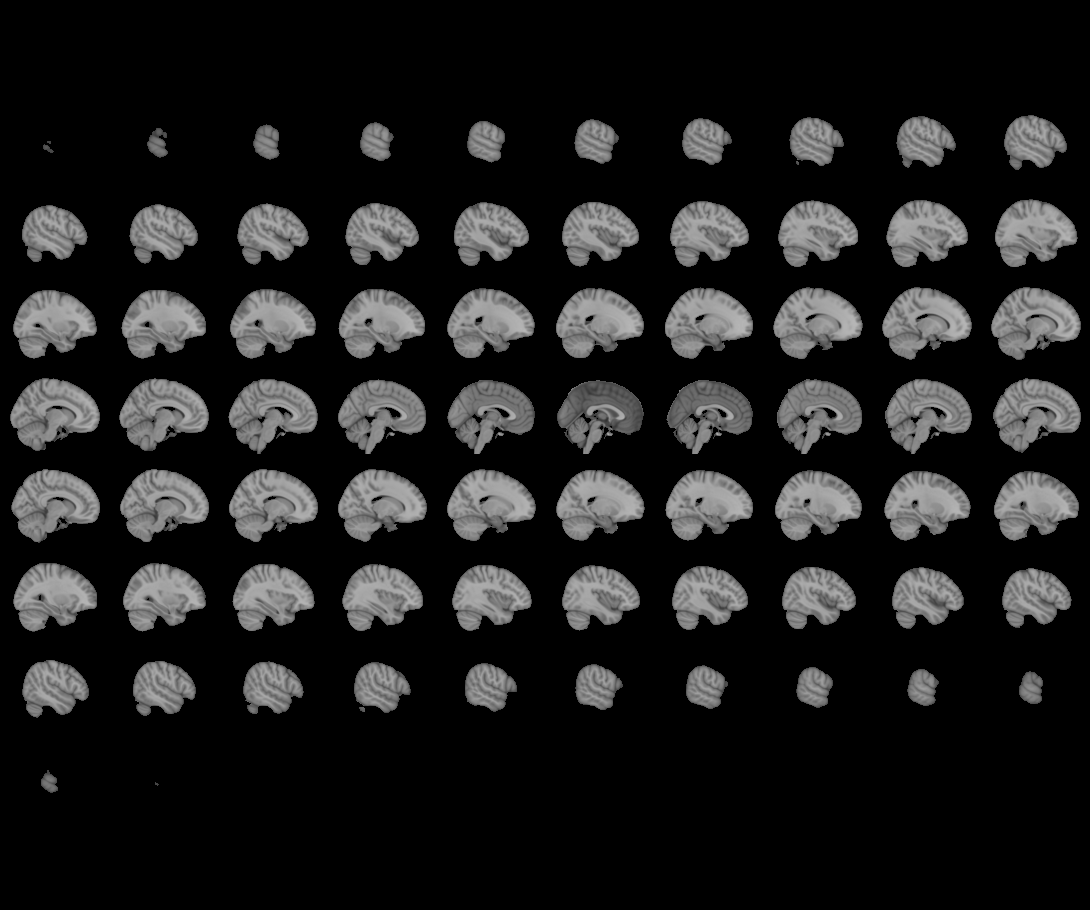

In [ ]:
view_img(isc_r_brain.to_nifti())


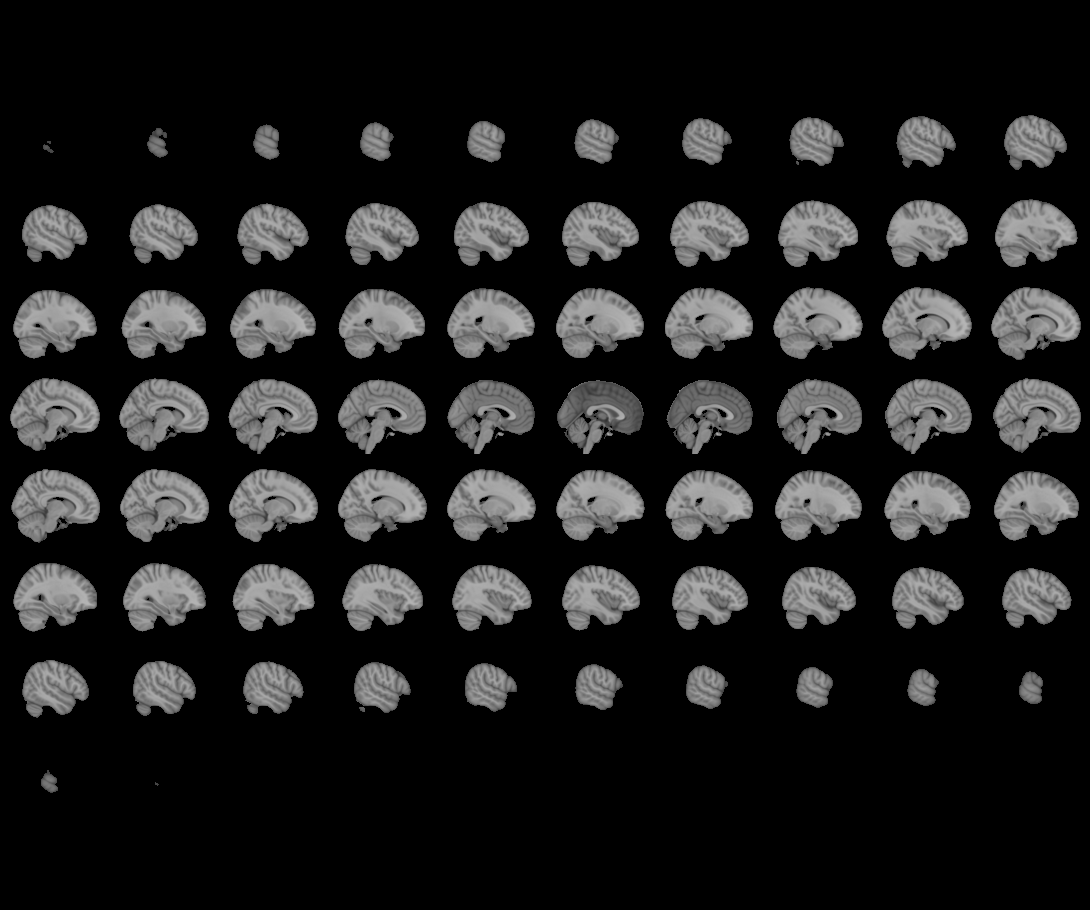
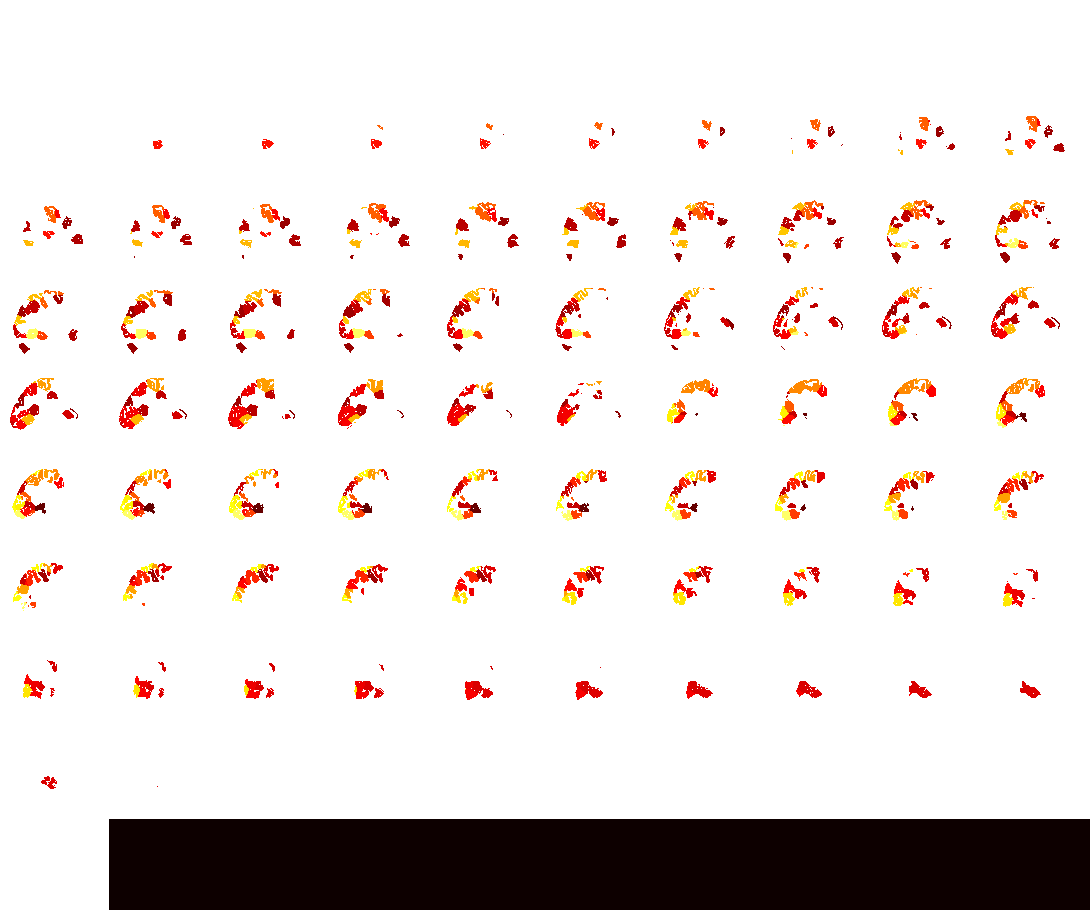

In [ ]:
view_img(threshold(isc_r_brain, isc_p_brain, thr = fdr(isc_p_brain.data)).to_nifti())

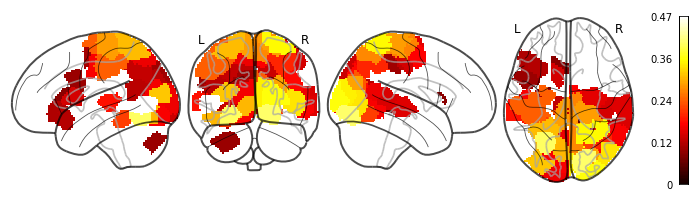

In [ ]:
plotting.plot_glass_brain(threshold(isc_r_brain, isc_p_brain, thr = fdr(isc_p_brain.data)).to_nifti(), colorbar = True, plot_abs = False, display_mode = 'lyrz', cmap = 'cold_hot')

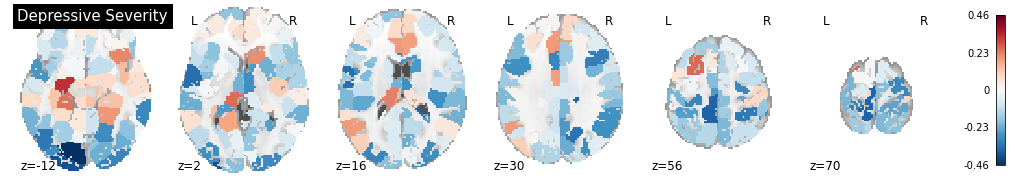

In [ ]:
plot_stat_map(mean_roi_isc_r_brain.to_nifti(), display_mode = 'z', cut_coords = 6, title = "Depressive Severity", cmap = 'RdBu_r')

In [ ]:
fdr_thr = fdr(pd.Series(mean_roi_isc_p).values)
plot_stat_map(threshold(mean_roi_isc_r_brain, mean_roi_isc_p_brain, thr = fdr_thr).to_nifti(), display_mode = 'z', cut_coords = 6, title = "Depressive Severity", cmap = 'RdBu_r')

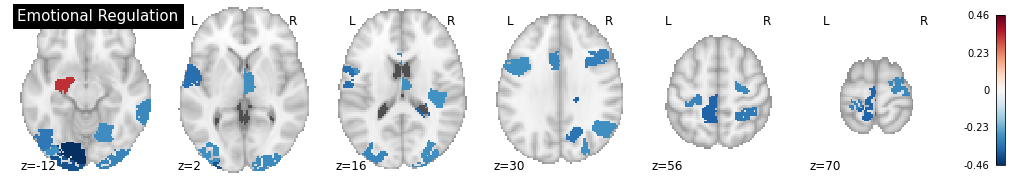

In [ ]:
plot_stat_map(threshold(mean_roi_isc_r_brain, mean_roi_isc_p_brain, thr = 0.05).to_nifti(), display_mode = 'z', cut_coords = 6, title = "Depressive Severity", cmap = 'RdBu_r')


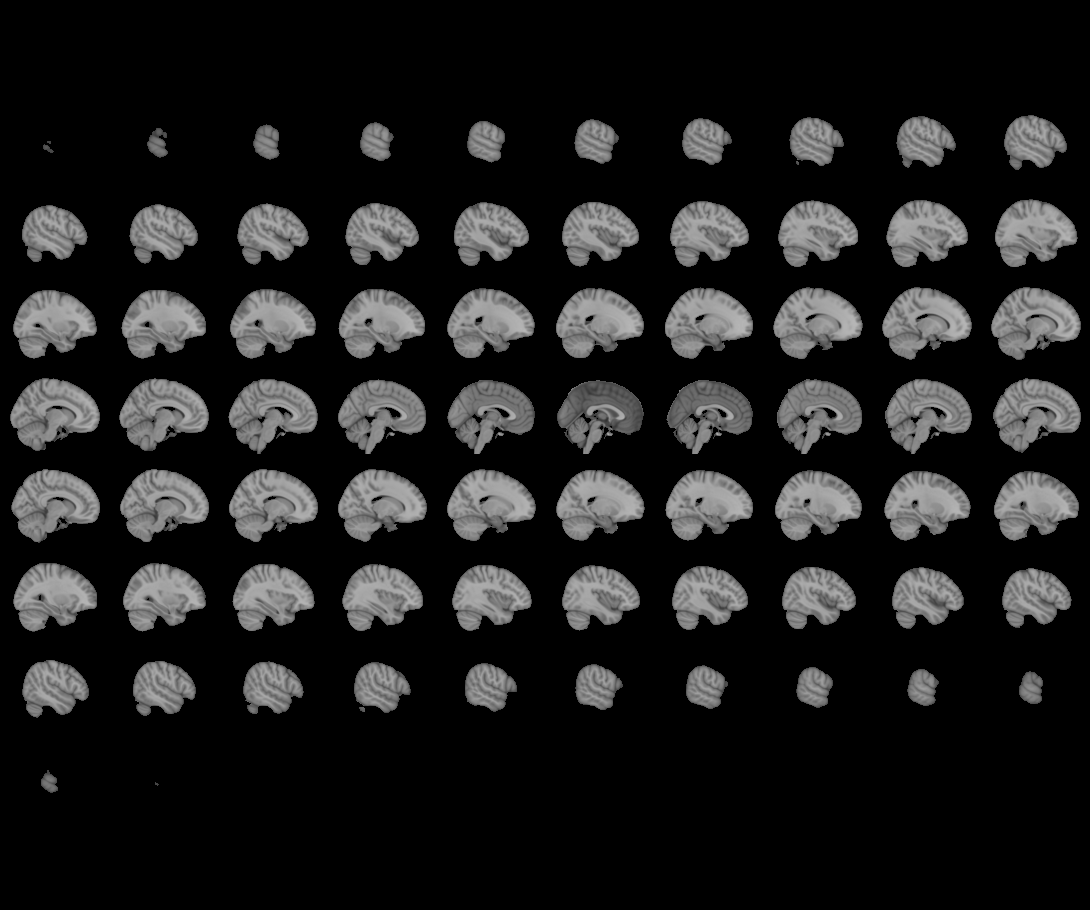
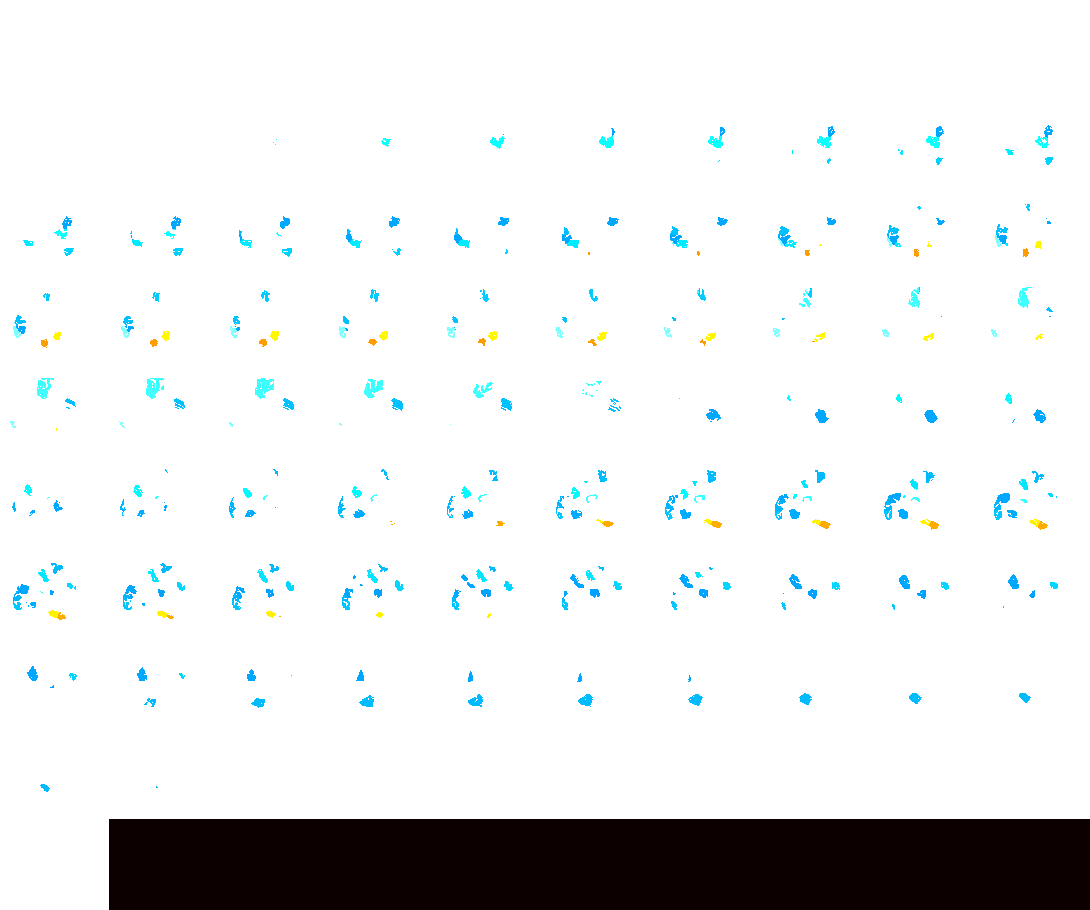

In [ ]:
view_img(threshold(mean_roi_isc_r_brain, mean_roi_isc_p_brain, thr = 0.05).to_nifti())

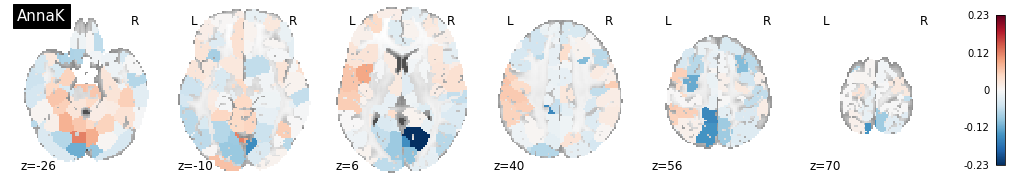

In [ ]:
vmax = np.max(np.abs([list(isrsa_nn_BDI.values()), list(isrsa_annak_BDI.values())]))
plot_stat_map(isrsa_nn_BDI_brain.to_nifti(), display_mode = 'z', cut_coords = 6, vmax = vmax, title = "Euclidean", cmap = 'RdBu_r')
plot_stat_map(isrsa_annak_BDI_brain.to_nifti(), display_mode = 'z', cut_coords = 6, vmax = vmax, title = "AnnaK", cmap = 'RdBu_r')


Euclidean Model for Emotional Regulation



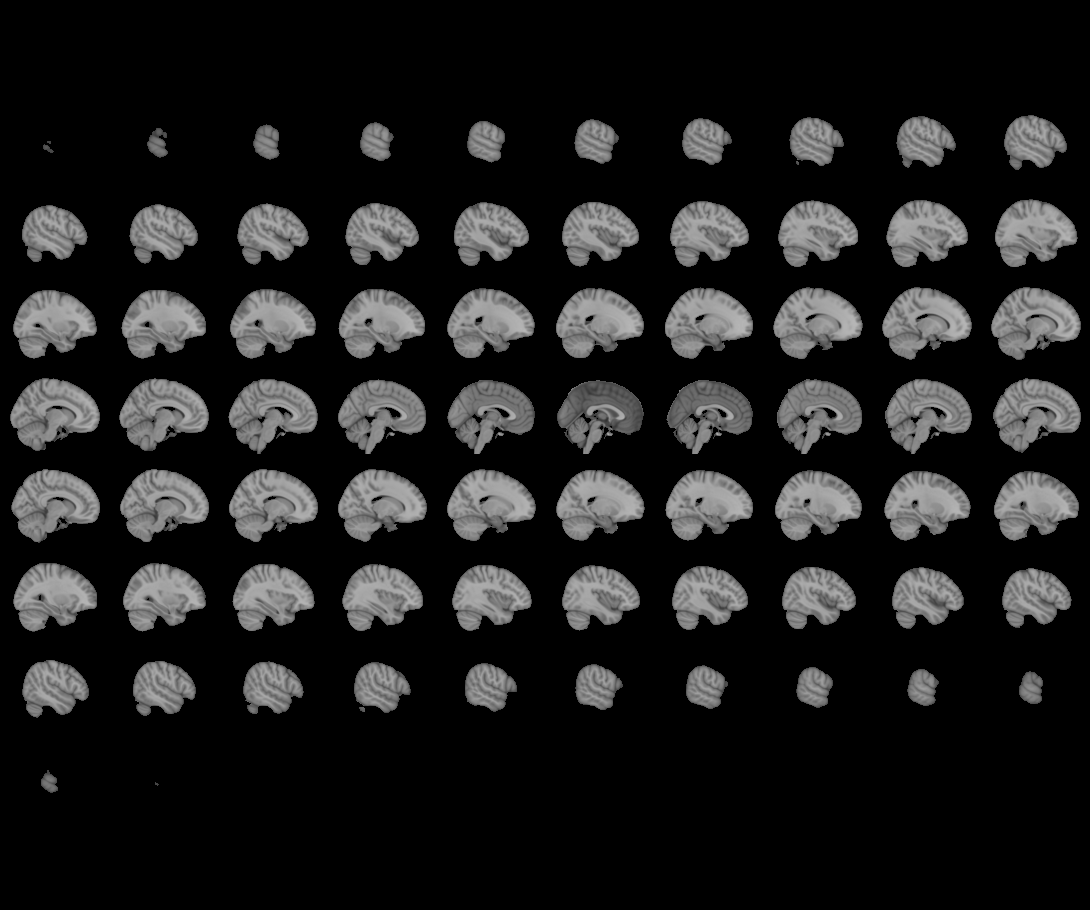
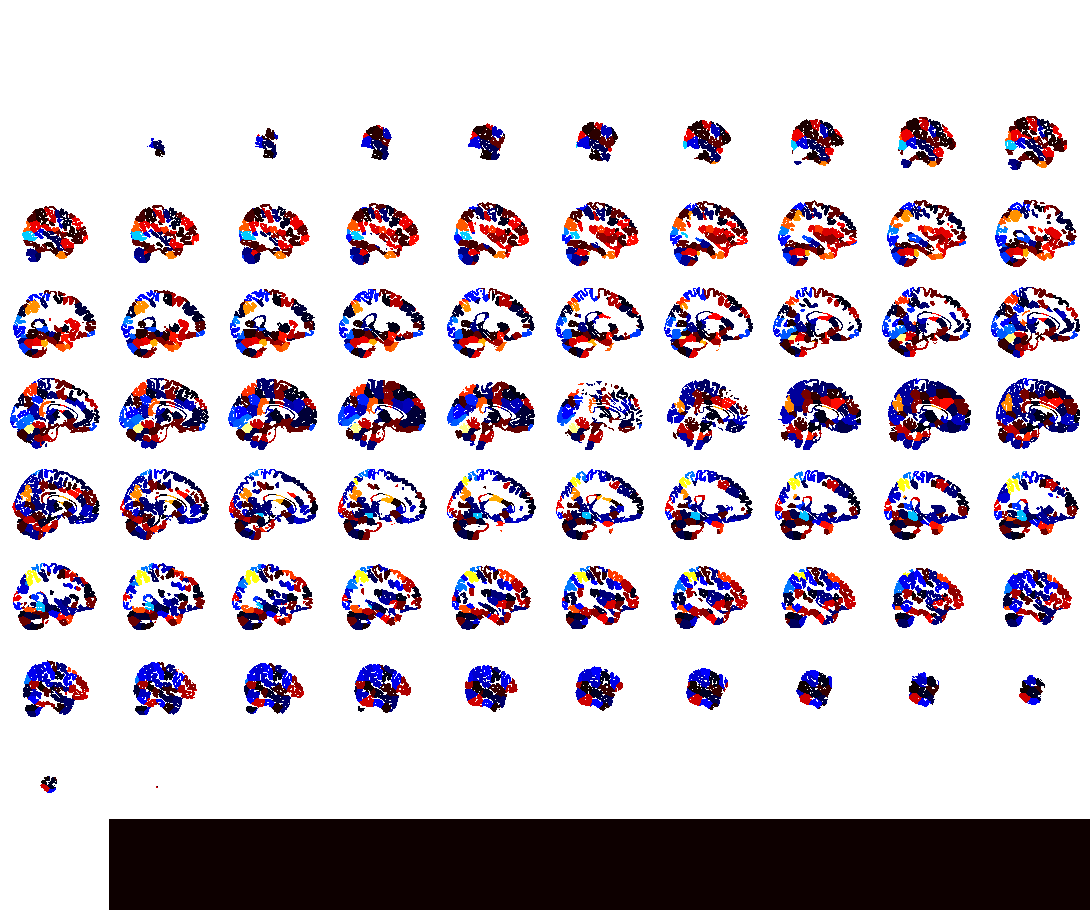

In [ ]:
print('Euclidean Model for Depressive Severity')
view_img(isrsa_nn_r_BDI_brain.to_nifti())

Anna Karenina Model for Depressive Severity



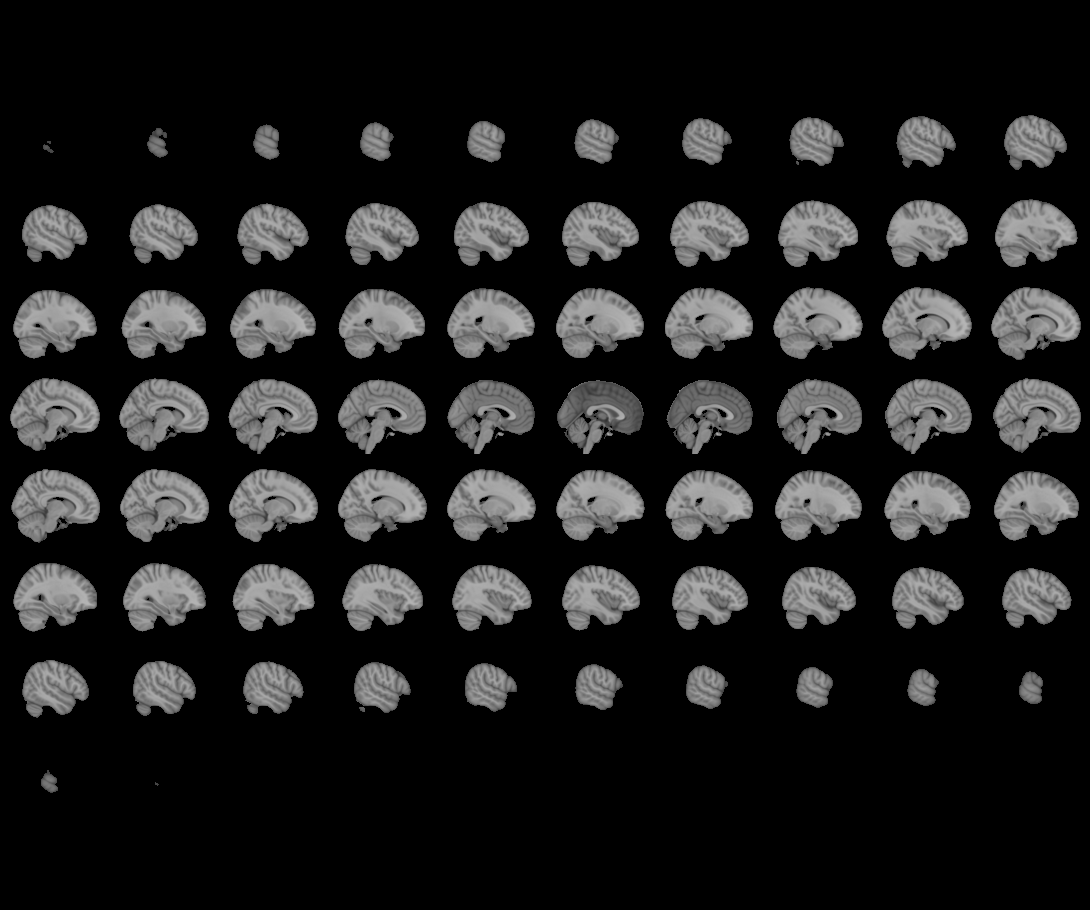

In [ ]:
print('Anna Karenina Model for Depressive Severity')
view_img(isrsa_annak_r_BDI_brain.to_nifti())

In [ ]:
fdr_thr_BDI = fdr(pd.Series(isrsa_nn_p_BDI).values)
plot_stat_map(threshold(isrsa_nn_r_BDI_brain, isrsa_nn_p_BDI_brain, thr = fdr_thr_BDI).to_nifti(), display_mode = 'z', cut_coords = 6, title = "Euclidean", cmap = 'RdBu_r')


In [ ]:
fdr_thr_BDI = fdr(pd.Series(isrsa_annak_p_BDI).values)
plot_stat_map(threshold(isrsa_annak_r_BDI_brain, isrsa_annak_p_BDI_brain, thr = fdr_thr_BDI).to_nifti(), display_mode = 'z', cut_coords = 6, title = "AnnaK", cmap = 'RdBu_r')


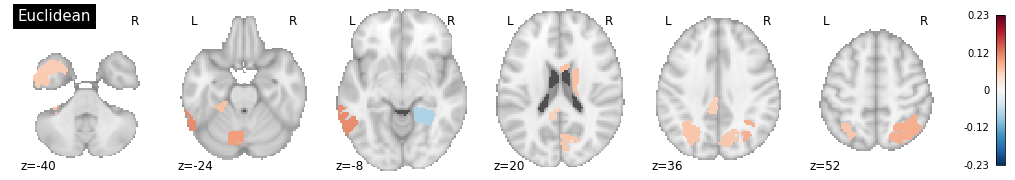

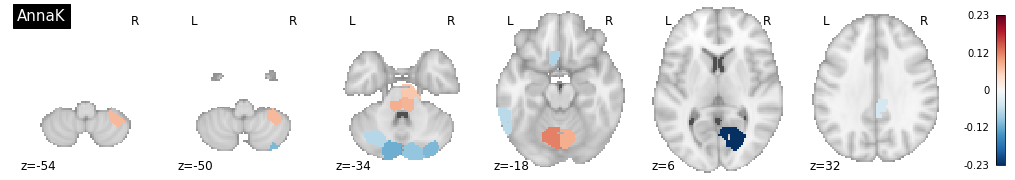

In [ ]:
vmax = np.max(np.abs([list(isrsa_nn_r_BDI.values()), list(isrsa_annak_r_BDI.values())]))
plot_stat_map(threshold(isrsa_nn_r_BDI_brain, isrsa_nn_p_BDI_brain, thr = 0.05).to_nifti(), display_mode = 'z', cut_coords = 6, vmax = vmax, title = "Euclidean", cmap = 'RdBu_r')
plot_stat_map(threshold(isrsa_annak_r_BDI_brain, isrsa_annak_p_BDI_brain, thr = 0.05).to_nifti(), display_mode = 'z', cut_coords = 6, vmax = vmax, title = "AnnaK", cmap = 'RdBu_r')


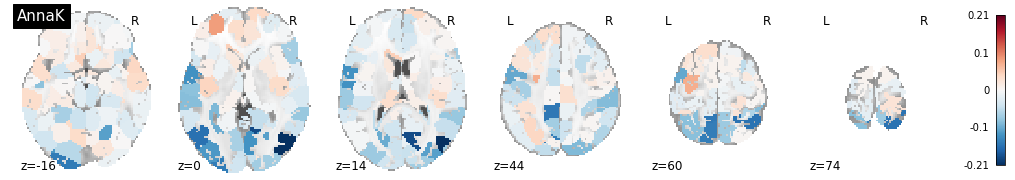

In [ ]:
vmax = np.max(np.abs([list(isrsa_nn_CERQ.values()), list(isrsa_annak_CERQ.values())]))
plot_stat_map(isrsa_nn_CERQ_brain.to_nifti(), display_mode = 'z', cut_coords = 6, vmax = vmax, title = "Euclidean", cmap = 'RdBu_r')
plot_stat_map(isrsa_annak_CERQ_brain.to_nifti(), display_mode = 'z', cut_coords = 6, vmax = vmax, title = "AnnaK", cmap = 'RdBu_r')


Euclidean Model for Emotional Regulation



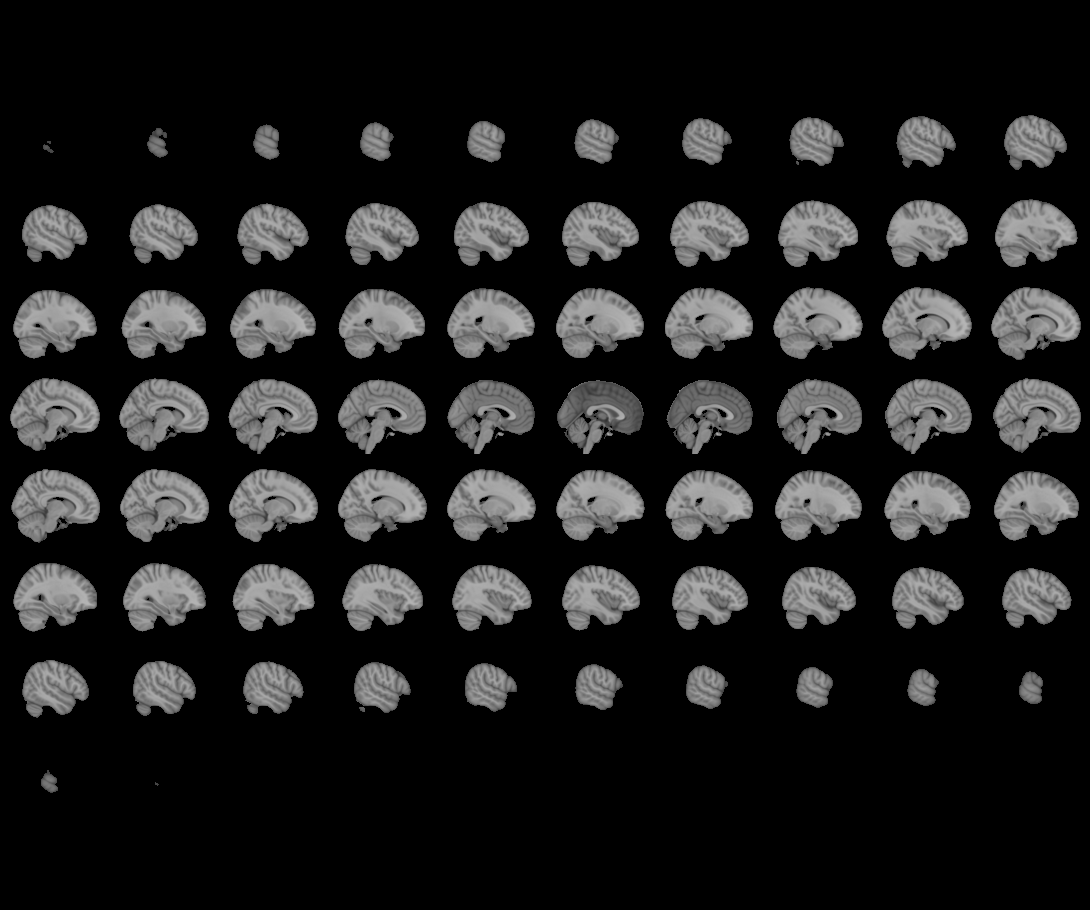

In [ ]:
print('Euclidean Model for Emotional Regulation')
view_img(isrsa_nn_r_CERQ_brain.to_nifti())


Anna Karenina Model for Emotional Regulation



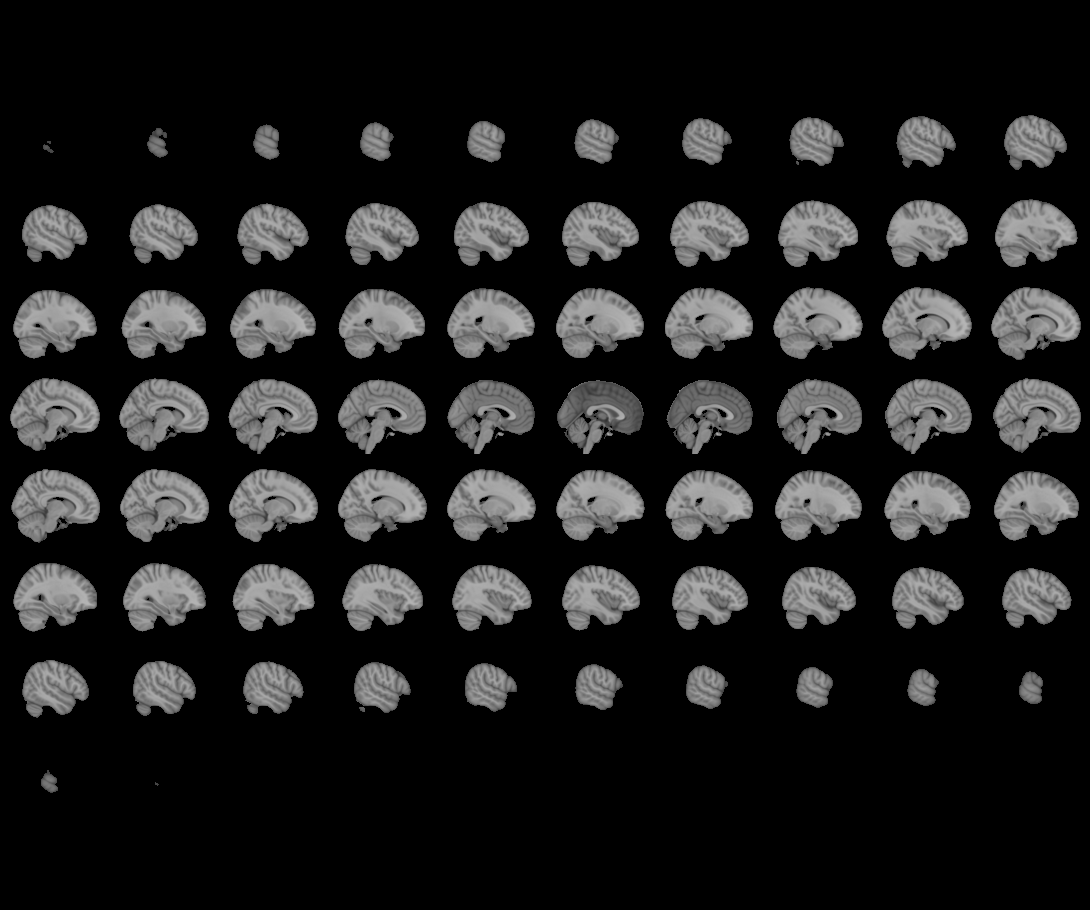
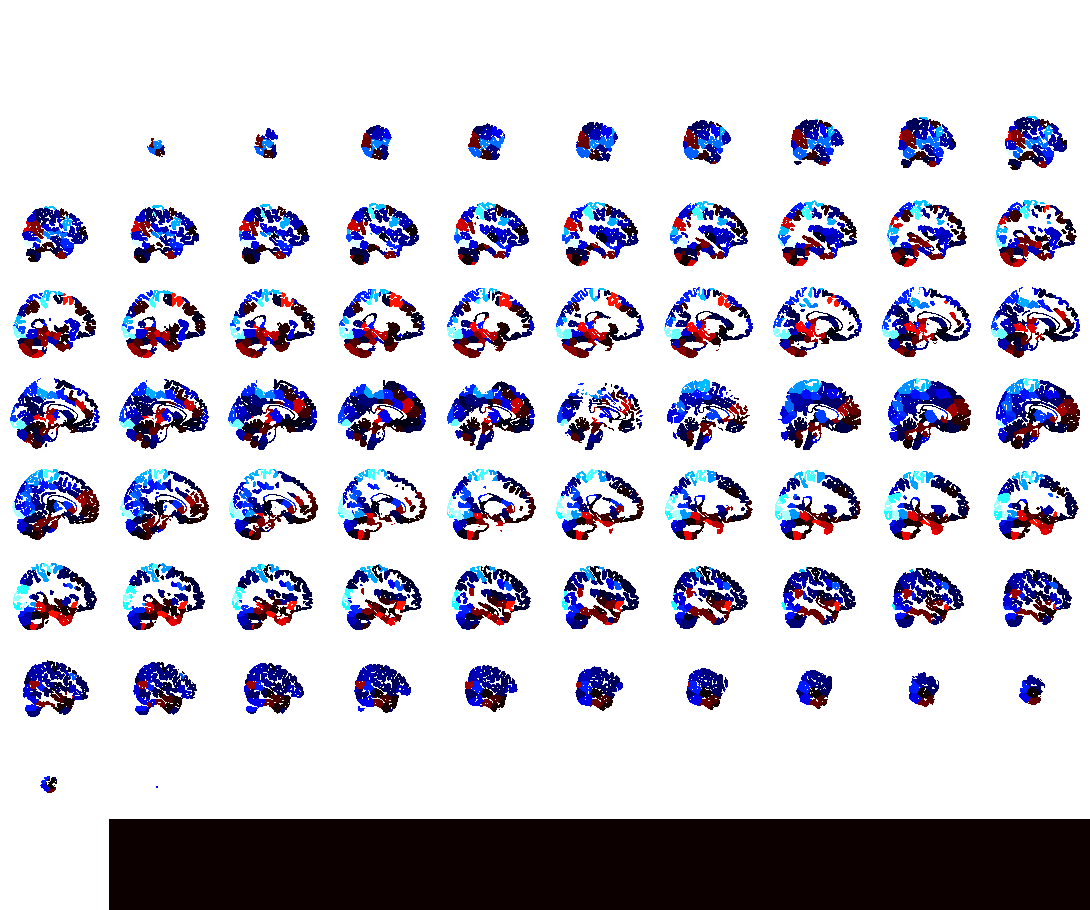

In [ ]:
print('Anna Karenina Model for Emotional Regulation')
view_img(isrsa_annak_r_CERQ_brain.to_nifti())


In [ ]:
fdr_thr_CERQ = fdr(pd.Series(isrsa_nn_p_CERQ).values)
plot_stat_map(threshold(isrsa_nn_r_CERQ_brain, isrsa_nn_p_CERQ_brain, thr = fdr_thr_CERQ).to_nifti(), display_mode = 'z', cut_coords = 6, title = "Euclidean", cmap = 'RdBu_r')


In [ ]:
fdr_thr_CERQ = fdr(pd.Series(isrsa_annak_p_CERQ).values)
plot_stat_map(threshold(isrsa_annak_r_CERQ_brain, isrsa_annak_p_CERQ_brain, thr = fdr_thr_CERQ).to_nifti(), display_mode = 'z', cut_coords = 6, title = "AnnaK", cmap = 'RdBu_r')


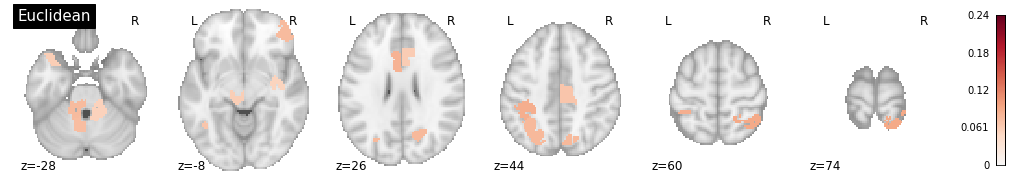

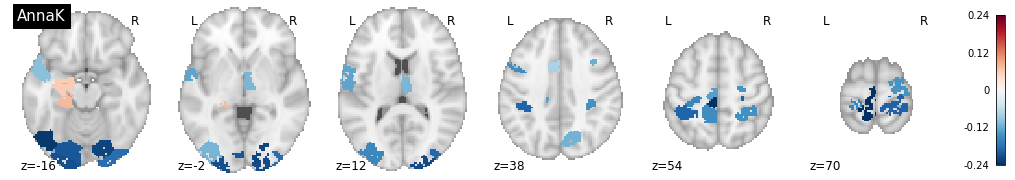

In [ ]:
vmax = np.max(np.abs([list(isrsa_nn_r_CERQ.values()), list(isrsa_annak_r_CERQ.values())]))
plot_stat_map(threshold(isrsa_nn_r_CERQ_brain, isrsa_nn_p_CERQ_brain, thr = 0.05).to_nifti(), display_mode = 'z', cut_coords = 6, vmax = vmax, title = "Euclidean", cmap = 'RdBu_r')
plot_stat_map(threshold(isrsa_annak_r_CERQ_brain, isrsa_annak_p_CERQ_brain, thr = 0.05).to_nifti(), display_mode = 'z', cut_coords = 6, vmax = vmax, title = "AnnaK", cmap = 'RdBu_r')


## Regression

### FC Estimates

In [ ]:
#linear regression to predict mean FC with age

meanFC = np.mean(corr, axis = 1)
pg.linear_regression(motion_df['Age'], meanFC)


names      coef        se  ...    adj_r2  CI[2.5%]  CI[97.5%]
0  Intercept  0.120205  0.058206  ... -0.009306  0.003174   0.237235
1        Age -0.002526  0.003411  ... -0.009306 -0.009384   0.004333

[2 rows x 9 columns]

In [ ]:
#test whether the residuals are normally distributed

lm = pg.linear_regression(motion_df['Age'], meanFC)
shapiro(lm.residuals_)


(0.9712949991226196, 0.2610936462879181)

In [ ]:
#multiple regression model to predict mean FC with age and head motion

meanFC = np.mean(corr, axis = 1)
pg.linear_regression(motion_df[['Age', 'mFD']], meanFC)


names      coef        se  ...    adj_r2  CI[2.5%]  CI[97.5%]
0  Intercept  0.053964  0.070195  ...  0.024342 -0.087251   0.195179
1        Age -0.000529  0.003571  ...  0.024342 -0.007712   0.006654
2        mFD  0.238915  0.146615  ...  0.024342 -0.056036   0.533866

[3 rows x 9 columns]

In [ ]:
#test whether the residuals are normally distributed

lm = pg.linear_regression(motion_df[['Age', 'mFD']], meanFC)
shapiro(lm.residuals_)


(0.9789501428604126, 0.5085817575454712)

In [ ]:
#multiple regression model to predict mean FC with age, head motion and behavioural scores

demo = "/content/drive/MyDrive/Year2/demographics_df.csv"
demographics_df = pd.read_csv(demo)
meanFC = np.mean(corr, axis = 1)

pg.linear_regression(demographics_df[['Age', 'mFD', 'BDI', 'malCERQ', 'adapCERQ']], meanFC)


names      coef        se  ...    adj_r2  CI[2.5%]  CI[97.5%]
0  Intercept  0.053345  0.073725  ... -0.035842 -0.095238   0.201928
1        Age -0.001033  0.003863  ... -0.035842 -0.008819   0.006754
2        mFD  0.240721  0.156011  ... -0.035842 -0.073698   0.555140
3        BDI  0.000432  0.000904  ... -0.035842 -0.001391   0.002254
4    malCERQ -0.000156  0.001034  ... -0.035842 -0.002239   0.001928
5   adapCERQ  0.000502  0.001708  ... -0.035842 -0.002940   0.003945

[6 rows x 9 columns]

In [ ]:
#test whether the residuals are normally distributed

lm = pg.linear_regression(demographics_df[['Age', 'mFD', 'BDI', 'malCERQ', 'adapCERQ']], meanFC)
shapiro(lm.residuals_)


(0.9841996431350708, 0.7367264032363892)

### ISC Estimates

In [ ]:
#compute the relationship between mean ISC and behavioural measures with Spearman's Rank using the permutation method set at 5K iterations
#linear regression model to predict mean ISC with age

mean_roi_isc = np.zeros((n_nodes, n_subs))

mean_roi_isc_r = {}
mean_roi_isc_p = {}

reg_p = {}

for node in range(len(similarity_matrices)):

  pairwise_sim_matrix = similarity_matrices[node].squareform()
  
  for sub in range(n_subs):

    corr_matrix = pairwise_sim_matrix[sub, :]
    corr_matrix_nondiag = np.delete(corr_matrix, sub)
    mean_roi_isc[node, sub] = np.mean(corr_matrix_nondiag)

  lm = pg.linear_regression(motion_df['Age'], mean_roi_isc[node, :])
  reg_p[node] = lm['pval'][1]


In [ ]:
p_val = np.array(list(reg_p.items()))
p_val_fdr = p_val[:, 1]
fdr(p_val_fdr)

import statsmodels as sm
sm.stats.multitest.fdrcorrection(p_val_fdr, alpha = 0.05, method = 'i', is_sorted = False)


In [ ]:
#compute the relationship between mean ISC and behavioural measures with Spearman's Rank using the permutation method set at 5K iterations
#multiple regression model to predict mean ISC with age and head motion

mean_roi_isc = np.zeros((n_nodes, n_subs))

mean_roi_isc_r = {}
mean_roi_isc_p = {}

reg_p = {}

for node in range(len(similarity_matrices)):

  pairwise_sim_matrix = similarity_matrices[node].squareform()
  
  for sub in range(n_subs):

    corr_matrix = pairwise_sim_matrix[sub, :]
    corr_matrix_nondiag = np.delete(corr_matrix, sub)
    mean_roi_isc[node, sub] = np.mean(corr_matrix_nondiag)

  lm = pg.linear_regression(motion_df[['Age', 'mFD']], mean_roi_isc[node, :])
  reg_p[node] = lm['pval'][1]


In [ ]:
p_val = np.array(list(reg_p.items()))
p_val_fdr = p_val[:, 1]
fdr(p_val_fdr)

import statsmodels as sm
sm.stats.multitest.fdrcorrection(p_val_fdr, alpha = 0.05, method = 'i', is_sorted = False)


In [ ]:
#compute the relationship between mean ISC and behavioural measures with Spearman's Rank using the permutation method set at 5K iterations
#linear regression model to predict mean ISC with age, head motion and behavioural scores

mean_roi_isc = np.zeros((n_nodes, n_subs))

mean_roi_isc_r = {}
mean_roi_isc_p = {}

reg_p = {}

for node in range(len(similarity_matrices)):

  pairwise_sim_matrix = similarity_matrices[node].squareform()
  
  for sub in range(n_subs):

    corr_matrix = pairwise_sim_matrix[sub, :]
    corr_matrix_nondiag = np.delete(corr_matrix, sub)
    mean_roi_isc[node, sub] = np.mean(corr_matrix_nondiag)

  lm = pg.linear_regression(demographics_df[['Age', 'mFD', 'BDI', 'malCERQ', 'adapCERQ']], mean_roi_isc[node, :])
  reg_p[node] = lm['pval'][1]


In [ ]:
p_val_fdr = p_val[:, 1]
fdr(p_val_fdr)

import statsmodels as sm
sm.stats.multitest.fdrcorrection(p_val_fdr, alpha = 0.05, method = 'i', is_sorted = False)


## Rain Cloud Plots for HE distribution

In [ ]:
!pip install ptitprince

In [ ]:
#read HE distributions at the network and ROI levels
demo = "/content/drive/MyDrive/Year2/demographics_HE_df.xlsx"
HE_df = pd.read_excel(demo, sheet_name = 'raincloud_network_HE')


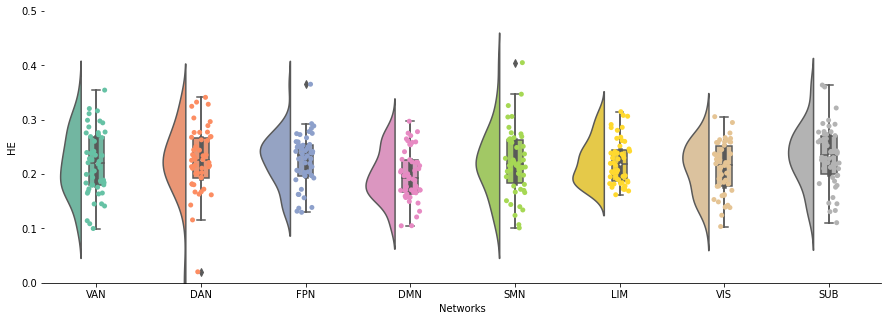

In [ ]:
import ptitprince as pt

f, ax = plt.subplots(figsize=(15, 5))
ax = pt.half_violinplot(x = "Networks", y = "HE", data = HE_df, width = .6, palette = 'Set2')
ax = sns.stripplot(x = "Networks", y = "HE", data = HE_df, jitter = 1, palette = 'Set2')
ax=sns.boxplot(x = "Networks", y = "HE", data = HE_df, width = .15, palette = 'Set2')
ax.set(ylim = (0, 0.5))
sns.despine(left = True)


## Comparing increases and decreases in dISC

In [ ]:
demo = "/content/drive/MyDrive/Year2/dISC_timecourse.xlsx"
dISC_df = pd.read_excel(demo, sheet_name = 'ttest')


In [ ]:
from scipy import stats
print("Network 1 - High vs. Low")
stats.shapiro(dISC_df['High_t1'].dropna()); stats.shapiro(dISC_df['Low_t1'])
print(stats.mannwhitneyu(dISC_df['High_t1'].dropna(), dISC_df['Low_t1'], alternative = "less"))

print("Network 2 - High vs. Low")
stats.shapiro(dISC_df['High_t2'].dropna()); stats.shapiro(dISC_df['Low_t2'])
print(stats.mannwhitneyu(dISC_df['High_t2'].dropna(), dISC_df['Low_t2'], alternative = "less"))

print("Network 3 - High vs. Low")
stats.shapiro(dISC_df['High_t3'].dropna()); stats.shapiro(dISC_df['Low_t3'])
print(stats.mannwhitneyu(dISC_df['High_t3'].dropna(), dISC_df['Low_t3'], alternative = "greater"))

print("Network 4 - High vs. Low")
stats.shapiro(dISC_df['High_t4'].dropna()); stats.shapiro(dISC_df['Low_t4'])
print(stats.mannwhitneyu(dISC_df['High_t4'].dropna(), dISC_df['Low_t4'], alternative = "less"))

print("Network 5 - High vs. Low")
stats.shapiro(dISC_df['High_t5'].dropna()); stats.shapiro(dISC_df['Low_t5'])
print(stats.mannwhitneyu(dISC_df['High_t5'].dropna(), dISC_df['Low_t5'], alternative = "greater"))

print("Network 6 - High vs. Low")
stats.shapiro(dISC_df['High_t6'].dropna()); stats.shapiro(dISC_df['Low_t6'])
print(stats.mannwhitneyu(dISC_df['High_t6'].dropna(), dISC_df['Low_t6'], alternative = "greater"))

print("Network 7 - High vs. Low")
stats.shapiro(dISC_df['High_t7'].dropna()); stats.shapiro(dISC_df['Low_t7'])
print(stats.mannwhitneyu(dISC_df['High_t7'].dropna(), dISC_df['Low_t7'], alternative = "less"))

print("Network 8 - High vs. Low")
stats.shapiro(dISC_df['High_t8'].dropna()); stats.shapiro(dISC_df['Low_t8'])
print(stats.mannwhitneyu(dISC_df['High_t8'].dropna(), dISC_df['Low_t8'], alternative = "less"))

print("Network 9 - High vs. Low")
stats.shapiro(dISC_df['High_t9'].dropna()); stats.shapiro(dISC_df['Low_t9'])
print(stats.mannwhitneyu(dISC_df['High_t9'].dropna(), dISC_df['Low_t9'], alternative = "less"))

print("Network 10 - High vs. Low")
stats.shapiro(dISC_df['High_t10'].dropna()); stats.shapiro(dISC_df['Low_t10'])
print(stats.mannwhitneyu(dISC_df['High_t10'].dropna(), dISC_df['Low_t10'], alternative = "less"))

print("Network 11 - High vs. Low")
stats.shapiro(dISC_df['High_t11'].dropna()); stats.shapiro(dISC_df['Low_t11'])
print(stats.mannwhitneyu(dISC_df['High_t11'].dropna(), dISC_df['Low_t11'], alternative = "greater"))

print("Network 12 - High vs. Low")
stats.shapiro(dISC_df['High_t12'].dropna()); stats.shapiro(dISC_df['Low_t12'])
print(stats.mannwhitneyu(dISC_df['High_t12'].dropna(), dISC_df['Low_t12'], alternative = "less"))

print("Network 13 - High vs. Low")
stats.shapiro(dISC_df['High_t13'].dropna()); stats.shapiro(dISC_df['Low_t13'])
print(stats.mannwhitneyu(dISC_df['High_t13'].dropna(), dISC_df['Low_t13'], alternative = "greater"))

print("Network 14 - High vs. Low")
stats.shapiro(dISC_df['High_t14'].dropna()); stats.shapiro(dISC_df['Low_t14'])
print(stats.mannwhitneyu(dISC_df['High_t14'].dropna(), dISC_df['Low_t14'], alternative = "less"))

print("Network 15 - High vs. Low")
stats.shapiro(dISC_df['High_t15'].dropna()); stats.shapiro(dISC_df['Low_t15'])
print(stats.mannwhitneyu(dISC_df['High_t15'].dropna(), dISC_df['Low_t15'], alternative = "greater"))


Network 1 - High vs. Low
MannwhitneyuResult(statistic=440.0, pvalue=9.291496501689546e-11)
Network 2 - High vs. Low
MannwhitneyuResult(statistic=542.0, pvalue=3.978609907345648e-09)
Network 3 - High vs. Low
MannwhitneyuResult(statistic=1788.0, pvalue=0.05547995035142193)
Network 4 - High vs. Low
MannwhitneyuResult(statistic=1724.0, pvalue=0.8890128241848995)
Network 5 - High vs. Low
MannwhitneyuResult(statistic=1672.0, pvalue=0.18198161085802633)
Network 6 - High vs. Low
MannwhitneyuResult(statistic=1692.0, pvalue=0.15241648518607304)
Network 7 - High vs. Low
MannwhitneyuResult(statistic=1576.0, pvalue=0.6353227406905195)
Network 8 - High vs. Low
MannwhitneyuResult(statistic=1363.0, pvalue=0.1804232213362022)
Network 9 - High vs. Low
MannwhitneyuResult(statistic=1447.0, pvalue=0.3383555039913265)
Network 10 - High vs. Low
MannwhitneyuResult(statistic=794.0, pvalue=9.388086588169596e-06)
Network 11 - High vs. Low
MannwhitneyuResult(statistic=1900.0, pvalue=0.012026214641712647)
Network 